# NBA - Finding patterns between physical attributes and performance using Machine Learning and Data Analysis: gradient boosting, random forests, clustering and more

## 0. Data loading & processing, feauture engineering

### 0-a) Loading the data

The data was collected as described/shown in the ´fetch_players.ipynb´ notebook, and is stored in multiple *csv* files. We load the data and take a look at it.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotting #Functions inside plotting.py file

In [3]:
df = pd.read_csv('data\player_bios3.csv')
#df_save = df.copy()
career_f = pd.read_csv('data\career_filtered.csv')
career_f_save = career_f.copy()
df

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,PLAYER_HEIGHT,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,COLLEGE,COUNTRY,...,PTS,REB,AST,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,AST_PCT,SEASON_ID
0,1630639,A.J. Lawson,1610612742,DAL,22.0,6-6,78.0,179.0,South Carolina,Canada,...,56,21,2,-20.1,0.046,0.152,0.189,0.589,0.032,2022-23
1,1631260,AJ Green,1610612749,MIL,23.0,6-5,77.0,190.0,Northern Iowa,USA,...,154,45,22,-4.9,0.016,0.105,0.159,0.607,0.092,2022-23
2,1631100,AJ Griffin,1610612737,ATL,19.0,6-6,78.0,220.0,Duke,USA,...,639,153,73,1.5,0.026,0.080,0.174,0.577,0.070,2022-23
3,203932,Aaron Gordon,1610612743,DEN,27.0,6-8,80.0,235.0,Arizona,USA,...,1109,446,203,12.1,0.086,0.136,0.206,0.617,0.129,2022-23
4,1628988,Aaron Holiday,1610612737,ATL,26.0,6-0,72.0,185.0,UCLA,USA,...,247,74,89,0.9,0.028,0.059,0.129,0.528,0.135,2022-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9773,203897,Zach LaVine,1610612741,CHI,25.0,6-6,78.0,200.0,UCLA,USA,...,1530,289,254,-4.4,0.019,0.125,0.312,0.568,0.218,2019-20
9774,1629668,Zach Norvell Jr.,1610612744,GSW,22.0,6-5,77.0,205.0,Gonzaga,USA,...,10,6,3,-32.3,0.000,0.207,0.147,0.402,0.091,2019-20
9775,1629015,Zhaire Smith,1610612755,PHI,21.0,6-3,75.0,205.0,Texas Tech,USA,...,8,2,2,-12.3,0.000,0.080,0.165,0.313,0.083,2019-20
9776,1629627,Zion Williamson,1610612740,NOP,19.0,6-6,78.0,284.0,Duke,USA,...,540,150,50,5.1,0.092,0.114,0.291,0.616,0.119,2019-20


### 0-b) Explanation of attributes: 

|Attribute|Meaning|Extra info|
|---|---|---|
|MIN|minutes   |   |
|FG, FG3, FT|Field goal (2 point goals), field goal 3 pointers, free throws ("penalty throws", 1 point)-  |M: Made (scored), A: attempted, PCT: percentage    |
| REB  |Rebounds   |OREB/DREB: Offensive/defensive rebound  |
|AST|Assists   |AST_PCT: Assist percentage   |
|STL|Steals   |   |
|BLK|Blocks   |   |
|TOV|Turnovers   | Negative statistic  |
|PF|Personal fouls   | Negative statistic  |
|PTS|Points   |   |
|---|--------------------------------------------------------------------| --------------------------------------------------------------------  |
|DRAFT|Each year before the season starts, 60(?) college newcomers can be drafted by teams   |More "promising" players are drafted in earlier rounds   |
|GP, GS|Games played, games started   |   |
|NET_RATING|Offensive rating - defensive rating   |For a player: measure for how many goals a team scores with him vs. allow in. Can be negative.   |
|USG_PCT|Usage percentage   | Estimate of percentage of team plays    |
|TS_PCT|True shooting percentage   | Measures how well a player shoots-  |


### 0-c) Sorting, selecting

Let's only select players (unique ID) from both data.

In [4]:
ids_bio = df['PLAYER_ID'].unique()
ids_career = career_f['PLAYER_ID'].unique()
ids = np.intersect1d(ids_bio, ids_career)
seasons = ["2022-23","2021-22","2020-21",'2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14','2012-13', '2011-12', '2010-11', '2009-10', '2008-09','2007-08', '2006-07', '2005-06', '2004-05', '2003-04',]

len(ids) #Also the ids in career_f, the ids in df are these and 3 more

2074

For our models, we shouldn't use highly related (correlated) features, at least for trees and forests. I'll select only one column for each "independent" attribute. 

In [5]:
#Only one data should be kept from each "category" (so there shouldn't be two assists related columns, because that is not independent)
cols_career = ['PLAYER_ID', 'SEASON_ID','PLAYER_AGE', #'GP', 'GS',
        'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS']
#Debatable: ... fouls, turnovers


career_f = career_f[cols_career]
career_f[career_f["PLAYER_ID"] == 57]

,PLAYER_ID,SEASON_ID,PLAYER_AGE,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,REB,AST,STL,BLK,TOV,PF,PTS
11346,57,2003-04,34.0,2779.0,317,688,0.461,49,142,0.345,148,172,0.860,329.0,347,151.0,41.0,155.0,186,831
11347,57,2004-05,35.0,997.0,83,204,0.407,10,39,0.256,50,56,0.893,123.0,153,43.0,13.0,68.0,61,226
11348,57,2004-05,35.0,528.0,47,128,0.367,5,23,0.217,20,22,0.909,54.0,46,37.0,5.0,36.0,45,119
11349,57,2004-05,35.0,1525.0,130,332,0.392,15,62,0.242,70,78,0.897,177.0,199,80.0,18.0,104.0,106,345
11350,57,2005-06,36.0,185.0,9,26,0.346,0,1,0.000,8,12,0.667,13.0,14,9.0,1.0,6.0,10,26
11351,57,2006-07,37.0,82.0,5,17,0.294,1,6,0.167,2,3,0.667,11.0,8,3.0,1.0,5.0,11,13


This are the stats for Player 57: statistics from multiple seasons.<br>
Some players have multiple rows for the same season, see 2004-05 above. This is due to playing in different teams (possibly the All-Star too).

Better to combine these:

In [6]:
def combine_given_rows(df):
    row_new = df.iloc[0].copy()
    sum_cols = ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A',
       'FTM', 'FTA', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS']
    avg_cols = ['FG_PCT', 'FG3_PCT', 'FT_PCT'] # Mean is not entirely correct, but it is a good approximation
    #select_one = ['PLAYER_ID', 'SEASON_ID','PLAYER_AGE']  #These are already selected with iloc[0]
    for col in sum_cols:
        row_new[col] = df[col].sum()
    for col in avg_cols:
        row_new[col] = df[col].mean()
    return row_new


for id in ids:
    for season in seasons:
        player_season_cases = career_f.loc[(career_f['PLAYER_ID'] == id) & (career_f['SEASON_ID'] == season)]
        if (len(player_season_cases) > 1):
            row_new = combine_given_rows(player_season_cases)
            career_f = (career_f.drop(player_season_cases.index)).reset_index(drop=True)
            career_f = pd.concat([career_f, row_new.to_frame().T], ignore_index=True).reset_index(drop=True)


Let's check if it worked:

In [7]:
career_f[career_f["PLAYER_ID"] == 57]

,PLAYER_ID,SEASON_ID,PLAYER_AGE,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,REB,AST,STL,BLK,TOV,PF,PTS
7773,57,2003-04,34.0,2779.0,317,688,0.461,49,142,0.345,148,172,0.86,329.0,347,151.0,41.0,155.0,186,831
7774,57,2005-06,36.0,185.0,9,26,0.346,0,1,0.0,8,12,0.667,13.0,14,9.0,1.0,6.0,10,26
7775,57,2006-07,37.0,82.0,5,17,0.294,1,6,0.167,2,3,0.667,11.0,8,3.0,1.0,5.0,11,13
8498,57,2004-05,35.0,3050.0,260,664,0.388667,30,124,0.238333,140,156,0.899667,354.0,398,160.0,36.0,208.0,212,690


Okay. It's better to filter out seasonal data that had too low playtime, they are not averaged well.<br>
Filter out low minute data for accuracy: all seasonal stats with less than 3 matches played

In [8]:
career_f = career_f[career_f["MIN"]> 144] #Time for 3 matches

Just for transparency, sort the rows back again.

In [9]:
career_f=career_f.sort_values(['PLAYER_ID', 'SEASON_ID'], ascending=[True, False]).reset_index(drop=True)

In [10]:
career_f

,PLAYER_ID,SEASON_ID,PLAYER_AGE,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,REB,AST,STL,BLK,TOV,PF,PTS
0,15,2005-06,35.0,228.0,24,61,0.393,9,33,0.273,2,5,0.4,23.0,13,6.0,1.0,11.0,20,59
1,15,2004-05,34.0,839.0,111,258,0.43,57,134,0.425,45,56,0.804,79.0,51,29.0,1.0,37.0,67,324
2,15,2003-04,33.0,703.0,72,191,0.377,43,122,0.352,14,16,0.875,73.0,26,16.0,5.0,29.0,42,201
3,43,2003-04,32.0,185.0,17,45,0.378,8,18,0.444,5,5,1.0,15.0,14,6.0,2.0,6.0,6,47
4,56,2006-07,38.0,1503.0,144,366,0.393,32,123,0.26,38,57,0.667,132.0,201,43.0,3.0,66.0,117,358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8465,1631230,2022-23,20.0,408.0,46,86,0.535,0,4,0.0,18,25,0.72,102.0,24,10.0,19.0,15.0,56,110
8466,1631254,2022-23,20.0,176.0,49,93,0.527,6,17,0.353,16,27,0.593,51.0,20,5.0,2.0,12.0,28,120
8467,1631260,2022-23,23.0,345.0,53,125,0.424,44,105,0.419,4,4,1.0,45.0,22,6.0,0.0,9.0,31,154
8468,1631288,2022-23,24.0,240.0,37,66,0.561,7,20,0.35,17,22,0.773,52.0,12,11.0,1.0,6.0,21,98


Whilst age is not correlated with height for these people, it probably correlates with performance, and we are guessing height from performance.<br>
This creates a discussion whether age may indeed matter, indirectly - this is interesting.

A crucial factor must be the minutes played. The more you play, the more you score. Let's see:

In [11]:
point_means = []; min_means = []; fg_pct_means = [];  three_pct_means = []; ft_pct_means = [];
ages = sorted(career_f['PLAYER_AGE'].unique()) #18-44

for age in ages:
    point_means.append(career_f[career_f['PLAYER_AGE'] == age]['PTS'].mean())
    min_means.append(career_f[career_f['PLAYER_AGE'] == age]['MIN'].mean())
    fg_pct_means.append(career_f[career_f['PLAYER_AGE'] == age]['FG_PCT'].mean())
    three_pct_means.append(career_f[career_f['PLAYER_AGE'] == age]['FG3_PCT'].mean())
    ft_pct_means.append(career_f[career_f['PLAYER_AGE'] == age]['FT_PCT'].mean())

Similarity in performance and minutes played:

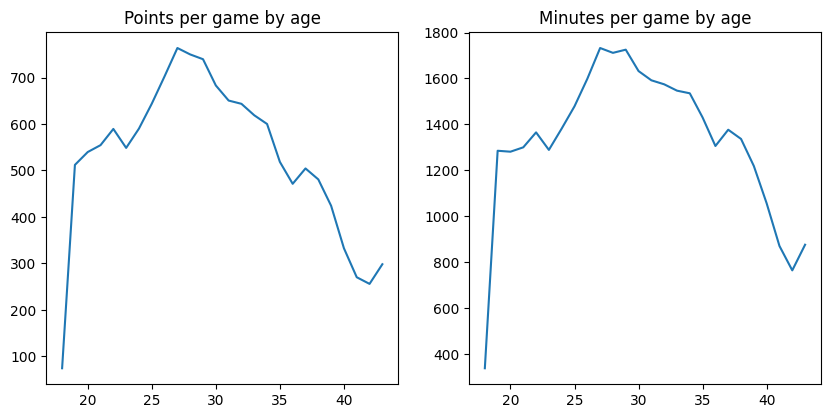

In [12]:
fig, ax = plt.subplots(nrows=1 ,ncols=2, figsize=(10, 6))
sns.lineplot(x=ages, y=point_means, ax=ax[0])
sns.lineplot(x=ages, y=min_means, ax=ax[1])
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
ax[0].set_title('Points per game by age')
ax[1].set_title('Minutes per game by age');

There is an obvious correlation between minutes played and points scored. So we have to adjust by "per minute" score. <br>

In the meantime we can check 'FG_PCT', 'FG3_PCT', and 'FT_PCT' as they are already normalized:

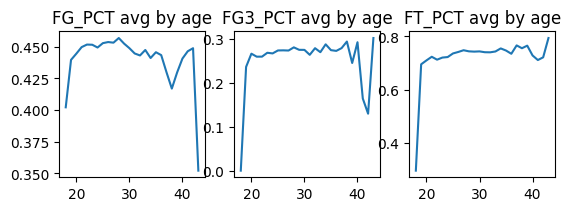

In [13]:
fig, ax = plt.subplots(nrows=1 ,ncols=3, )
sns.lineplot(x=ages, y=fg_pct_means, ax=ax[0])
sns.lineplot(x=ages, y=three_pct_means, ax=ax[1])
sns.lineplot(x=ages, y=ft_pct_means, ax=ax[2])
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
ax[2].set_aspect(1.0/ax[2].get_data_ratio(), adjustable='box')
ax[0].set_title('FG_PCT avg by age')
ax[1].set_title('FG3_PCT avg by age')
ax[2].set_title('FT_PCT avg by age');

Aside from "very young" and "very old" players, the age seems to matter little but can matter. For (relatively) old players the statistics can vary like a roller coaster. Probably it is better to filter too old players and too young players, but one could try both methods.

In [14]:
def normalize_by_min(df=career_f, cols=career_f.columns, mins=career_f['MIN']):
    for col in cols:
        df[col] = df[col]/mins
        df = df.rename(columns={col: col + '_PM'})
    return df

norm_cols = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'REB', 'AST', 'STL',
             'BLK', 'TOV', 'PF', 'PTS']
career_f = normalize_by_min(career_f, cols=norm_cols, mins=career_f['MIN'])
career_f

,PLAYER_ID,SEASON_ID,PLAYER_AGE,MIN,FGM_PM,FGA_PM,FG_PCT,FG3M_PM,FG3A_PM,FG3_PCT,FTM_PM,FTA_PM,FT_PCT,REB_PM,AST_PM,STL_PM,BLK_PM,TOV_PM,PF_PM,PTS_PM
0,15,2005-06,35.0,228.0,0.105263,0.267544,0.393,0.039474,0.144737,0.273,0.008772,0.02193,0.4,0.100877,0.057018,0.026316,0.004386,0.048246,0.087719,0.258772
1,15,2004-05,34.0,839.0,0.1323,0.307509,0.43,0.067938,0.159714,0.425,0.053635,0.066746,0.804,0.09416,0.060787,0.034565,0.001192,0.0441,0.079857,0.386174
2,15,2003-04,33.0,703.0,0.102418,0.271693,0.377,0.061166,0.173542,0.352,0.019915,0.02276,0.875,0.103841,0.036984,0.02276,0.007112,0.041252,0.059744,0.285917
3,43,2003-04,32.0,185.0,0.091892,0.243243,0.378,0.043243,0.097297,0.444,0.027027,0.027027,1.0,0.081081,0.075676,0.032432,0.010811,0.032432,0.032432,0.254054
4,56,2006-07,38.0,1503.0,0.095808,0.243513,0.393,0.021291,0.081836,0.26,0.025283,0.037924,0.667,0.087824,0.133733,0.028609,0.001996,0.043912,0.077844,0.23819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8465,1631230,2022-23,20.0,408.0,0.112745,0.210784,0.535,0.0,0.009804,0.0,0.044118,0.061275,0.72,0.25,0.058824,0.02451,0.046569,0.036765,0.137255,0.269608
8466,1631254,2022-23,20.0,176.0,0.278409,0.528409,0.527,0.034091,0.096591,0.353,0.090909,0.153409,0.593,0.289773,0.113636,0.028409,0.011364,0.068182,0.159091,0.681818
8467,1631260,2022-23,23.0,345.0,0.153623,0.362319,0.424,0.127536,0.304348,0.419,0.011594,0.011594,1.0,0.130435,0.063768,0.017391,0.0,0.026087,0.089855,0.446377
8468,1631288,2022-23,24.0,240.0,0.154167,0.275,0.561,0.029167,0.083333,0.35,0.070833,0.091667,0.773,0.216667,0.05,0.045833,0.004167,0.025,0.0875,0.408333


### 0-d) What attributes do we need?<br> Selecting attributes for prediction (feature engineering)

Let's go through all categories one by one:

- Position: Can play a significant role in statistics, and can "suggest" the player's physical attributes. However, there was no data particularly on which position a player is playing preferably. This is because it can change game to game, and to obtain that data I'd have to fetch it from all matches and look at where they play most commonly. This, in case of this API is not really feasible, would take unbearable time. So I have to work without this attribute. (Positions: Point guard, Shooting guard, Small forward, Power forward, Center)<br>
- Age: Hard to tell. As I said, it doesn't correlate with height, but it correlates with performance on which we predict height. Especially for clustering. I think for "attempts" stats, age should not really matter however. <br>
- FG, FG3, FT: I would drop FT_PCT, it's "throwing skill". FTA is not relevant, but FTM may be. For field goals, my thought was "made" is more important than attempt as it suggests success, and made/attempt ratio would suggest even better how successful the player is. <br>
But one of the key ideas I wanted to know is whether "smaller" players tend to play different than other players: do they throw more from far away, as they struggle to penetrate from close, or it's exactly the opposite: they use their agility to score from close? For that, attempts per minute may be a better predictor. I decided on first using attempts alongside made/attempt ratio, we may get some results like short players are less successful in scoring 2-pointers.<br>
- REB: I would either drop OREB, DREB, and keep REB(_PM) with position, or keep only OREB+DREB. Since we don't have position, I keep OREB and DREB as indicators on "position". (As we see later on, these turned out to be some of the most important attributes). BLK: keep, because some short players even have 0 blocks after many matches. TOV: drop, I guess not really relevant with height, PF: maybe relevant I'll keep it at first. STL: Not sure, but from the data it spans really thin, probably not a good predictor so I drop.<br>
- AST: Drop all. It is more of a skill/team stat. (Although might have some significance, like in soccer the small, fast, agile wingers cross the ball to the big, strong striker who can head it in.) <br>
- PTS: Not needed, we have other points stats <br>
- DRAFT: I'd skip. I thought it can find extreme cases like Giannis being 6'11, but he was only 15th pick.<br>
- NET_RATING: Skip. USG: Undecided, TS: I'd keep. <br>
- Anything else: skip. <br>

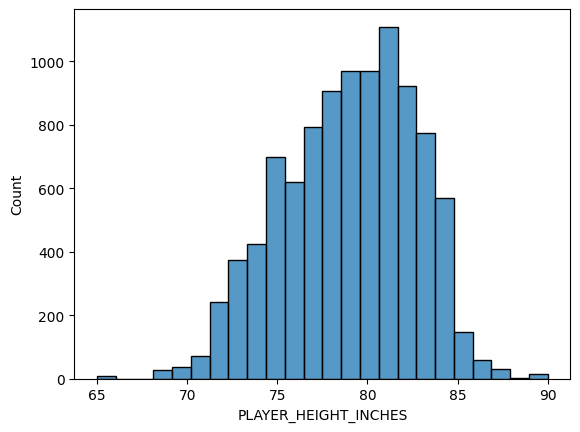

In [15]:
df_r =df[['PLAYER_ID','SEASON_ID', 'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 
    'OREB_PCT', 'DREB_PCT', 'USG_PCT', 'TS_PCT',]]

career_f = career_f[['PLAYER_ID', 'SEASON_ID', 'PLAYER_AGE', 'MIN', 
        'FGA_PM', 'FG_PCT', 'FG3A_PM', 'FG3_PCT', 'FTM_PM', #'STL_PM', 
        'BLK_PM', 'PF_PM',]]

sns.histplot(data=df_r, x="PLAYER_HEIGHT_INCHES", bins=len(df_r['PLAYER_HEIGHT_INCHES'].unique()));

Look at the outlier:

In [16]:
df_r[df_r['PLAYER_HEIGHT_INCHES']==65]

,PLAYER_ID,SEASON_ID,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT
5302,1863,2011-12,36.0,65.0,133.0,0.000,0.081,0.208,0.458
5774,1863,2010-11,35.0,65.0,133.0,0.018,0.048,0.235,0.526
6222,1863,2009-10,34.0,65.0,133.0,0.015,0.055,0.200,0.498
7118,1863,2007-08,32.0,65.0,133.0,0.016,0.045,0.183,0.467
7565,1863,2006-07,31.0,65.0,133.0,0.023,0.044,0.209,0.548
8029,1863,2005-06,30.0,65.0,133.0,0.013,0.041,0.229,0.513
8479,1863,2004-05,29.0,65.0,133.0,0.017,0.050,0.214,0.530
8935,1863,2003-04,28.0,65.0,133.0,0.022,0.055,0.219,0.501


Now, let's see some intriguing attributes (worthy to check manually, e.g. rebounds by height):

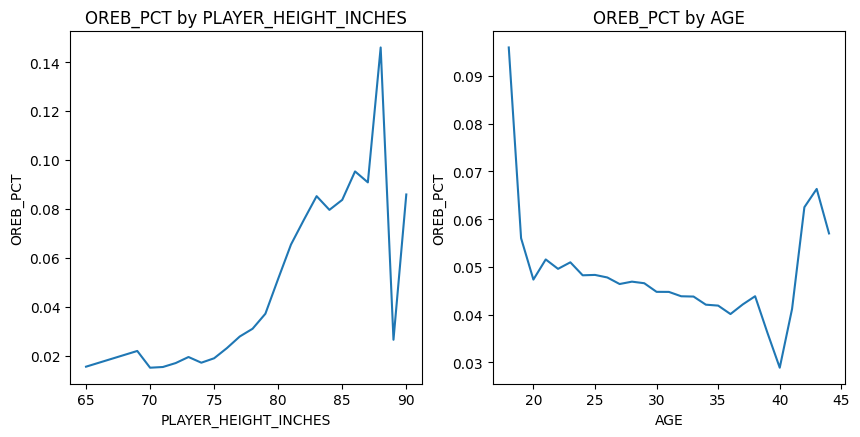

In [17]:
plotting.plot_A_by_B_and_C(df_r, A='OREB_PCT', B='PLAYER_HEIGHT_INCHES', C='AGE')

Plot again, but with limited age range:

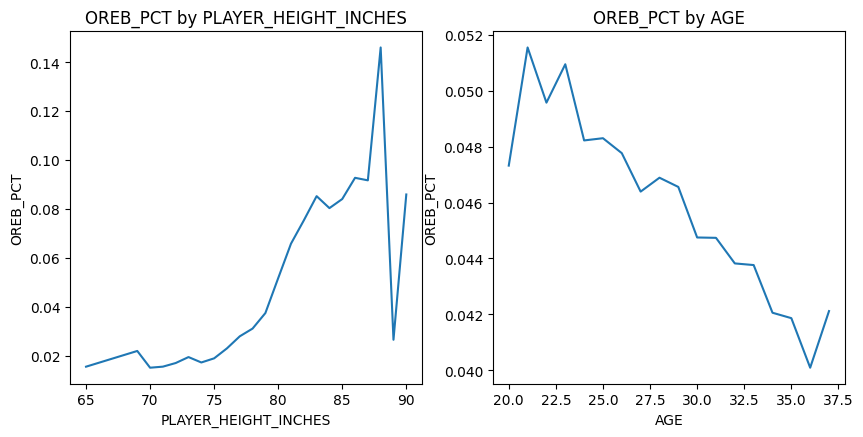

In [18]:
plotting.plot_A_by_B_and_C(df_r[df_r['AGE'].isin(list(range(20,38))) ])

Put multiple other attributes on one figure:

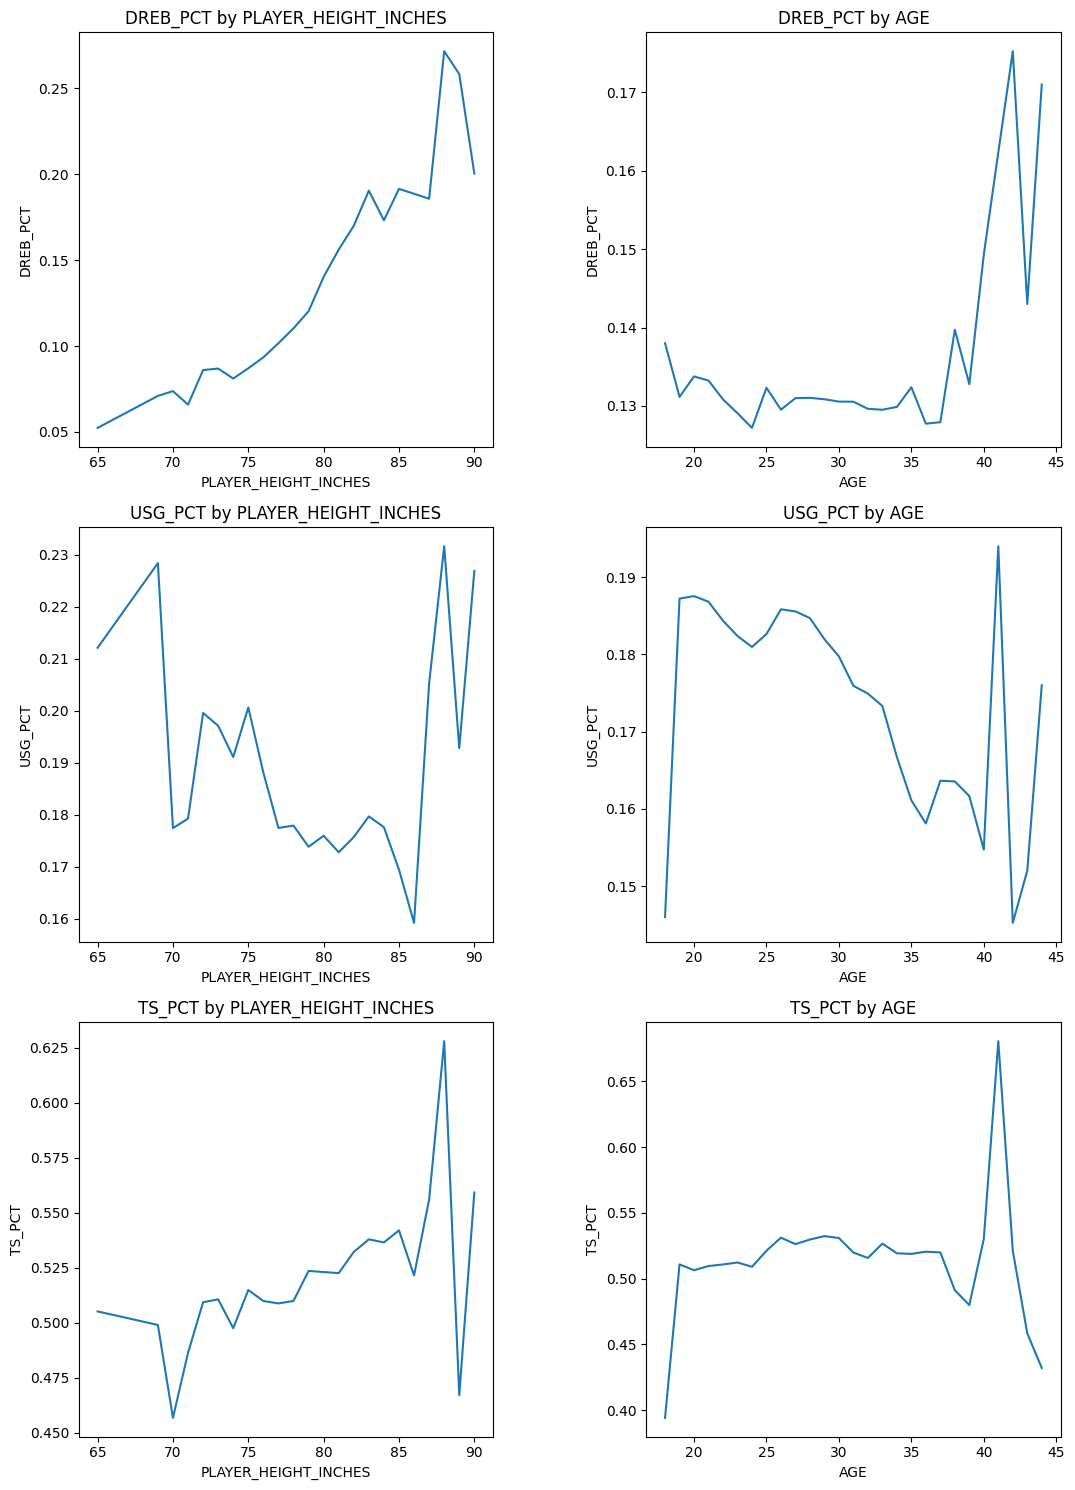

In [19]:
plotting.plot_As_by_Bs_and_Cs(df_r, As=['DREB_PCT', 'USG_PCT', 'TS_PCT'], Bs=['PLAYER_HEIGHT_INCHES']*3, Cs=['AGE']*3)

The plots further show that "too" old/young players may have to be filtered out for more consistent results.<br>
This is our next step.

USG_PCT does not seem to be a good predictor (well, there is some trend, but very "bumpy", and it rather correlates with age). <br>
True shot percentage is not correlated with age; there is some upwards trend with height, but it is not very strong. We keep it just in case. <br>

In [20]:
df_r = df_r[df_r['AGE'].isin(list(range(20,38))) ].reset_index(drop=True)
career_f = career_f[career_f['PLAYER_AGE'].isin(list(range(20,38))) ].reset_index(drop=True)

df_r = df_r.drop(columns=['USG_PCT', ])
df_r

,PLAYER_ID,SEASON_ID,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,OREB_PCT,DREB_PCT,TS_PCT
0,1630639,2022-23,22.0,78.0,179.0,0.046,0.152,0.589
1,1631260,2022-23,23.0,77.0,190.0,0.016,0.105,0.607
2,203932,2022-23,27.0,80.0,235.0,0.086,0.136,0.617
3,1628988,2022-23,26.0,72.0,185.0,0.028,0.059,0.528
4,1630174,2022-23,23.0,77.0,215.0,0.033,0.119,0.566
...,...,...,...,...,...,...,...,...
9591,1628380,2019-20,22.0,83.0,250.0,0.095,0.149,0.538
9592,203897,2019-20,25.0,78.0,200.0,0.019,0.125,0.568
9593,1629668,2019-20,22.0,77.0,205.0,0.000,0.207,0.402
9594,1629015,2019-20,21.0,75.0,205.0,0.000,0.080,0.313


Let's "perfectly" combine the two datasets:

In [21]:
ids_bio = df_r['PLAYER_ID'].unique()
ids_career = career_f['PLAYER_ID'].unique()
ids = np.intersect1d(ids_bio, ids_career)

df_r = df_r[df_r['PLAYER_ID'].isin(ids) ].reset_index(drop=True) #Don't need to do with career_f, it is the same as the intersection
#The above is not necessary furthermore, but I keep it for cleanness. We filter by id-season pair below

#Find all common id-season pairs
id_season_pairs_bio = (df_r[['PLAYER_ID', 'SEASON_ID']].to_numpy().tolist())
id_season_pairs_career = career_f[['PLAYER_ID', 'SEASON_ID']].to_numpy().tolist()
A = set(tuple(x) for x in id_season_pairs_bio); B = set(tuple(x) for x in id_season_pairs_career)
id_season_pairs = ([x for x in A & B])

df_r = df_r[df_r[['PLAYER_ID', 'SEASON_ID']].apply(tuple, axis=1).isin(id_season_pairs) ].reset_index(drop=True)
career_f = career_f[career_f[['PLAYER_ID', 'SEASON_ID']].apply(tuple, axis=1).isin(id_season_pairs) ].reset_index(drop=True)
data = pd.merge(df_r, career_f, on=['PLAYER_ID', 'SEASON_ID'], how='inner'); data = data.drop(columns=['PLAYER_AGE'])
data = (data.dropna()).reset_index(drop=True)
data

,PLAYER_ID,SEASON_ID,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,OREB_PCT,DREB_PCT,TS_PCT,MIN,FGA_PM,FG_PCT,FG3A_PM,FG3_PCT,FTM_PM,BLK_PM,PF_PM
0,1630639,2022-23,22.0,78.0,179.0,0.046,0.152,0.589,217.0,0.40553,0.662667,0.230415,0.266667,0.018433,0.0,0.101382
1,1631260,2022-23,23.0,77.0,190.0,0.016,0.105,0.607,345.0,0.362319,0.424,0.304348,0.419,0.011594,0.0,0.089855
2,203932,2022-23,27.0,80.0,235.0,0.086,0.136,0.617,2055.0,0.370316,0.564,0.084185,0.347,0.092944,0.024818,0.062774
3,1628988,2022-23,26.0,72.0,185.0,0.028,0.059,0.528,845.0,0.260355,0.418,0.104142,0.409,0.031953,0.014201,0.093491
4,1630174,2022-23,23.0,77.0,215.0,0.033,0.119,0.566,1816.0,0.32489,0.427,0.172907,0.366,0.065529,0.018722,0.129405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8317,1626195,2019-20,26.0,83.0,250.0,0.105,0.243,0.576,375.0,0.370667,0.532,0.058667,0.227,0.098667,0.018667,0.085333
8318,201163,2019-20,33.0,80.0,235.0,0.014,0.164,0.531,734.0,0.249319,0.404,0.16485,0.306,0.027248,0.016349,0.107629
8319,1627812,2019-20,27.0,72.0,178.0,0.011,0.085,0.528,530.0,0.354717,0.42,0.149057,0.304,0.067925,0.007547,0.071698
8320,1628380,2019-20,22.0,83.0,250.0,0.095,0.149,0.538,290.0,0.234483,0.471,0.065517,0.368,0.02069,0.017241,0.124138


Save our data:

In [22]:
data.to_csv('data\data_combined.csv', index=False)

### 0-e) Possible problems, thoughts

Since data contains multiple season stats for most players, it's longitudinal data, that is "biased". It has to be decided how to handle this.<br>
One can combine all rows for each player, but then we'd lose the age attribute. It may be that matters more than age in general is minimal_age, how old the player was when he got into the NBA.<br>
Another idea is renormalizing data based on age, but I personally think that'd result in bad results (did not try it).<br>
The simplest idea is just to look at players of the same age - however that'd result in too small input data.<br>
Also a problem for output: we'd have multiple seasons data for one player, so the classifier will need to guess a player's height multiple times, with different (seasonal) data. <br>

Other "discussion" is what to do with outliers in the target. We see that things get "weird" at height in inches 88+, but arguibly it would part of the problem to predict the height of these players.<br>

About age, as said before: Even if it doesn't directly correlate with height, it can correlate with performance, and we are guessing height from performance.<br>
What we will observe, is that simple tree and forest models which are only capable of learning pairwise relationships (between the target and one feature) will not be able to make use of age data. Contrary, more complex models like gradient boosting can learn these multidirectional (think of a hypergraph) relationships.<br>


## 1. Prediction: Classifiers

Our classifiers:

1. Entropy-based decision tree + Random forest
2. Gradient boosting (see section 3)

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor #For comparison

random_state = 20001104

Train-test split: I have to split the players into two sets, not the data. If I split the data, some players may be in the test and train dataset too, with different season data. <br>

In [24]:
id_x,id_y=train_test_split(ids, test_size=0.15, random_state=random_state) #Will not perfectly be 85-15, because this is picking player ids, not rows
print("Players:", len(ids), len(id_x), len(id_y))

train = data[data['PLAYER_ID'].isin(id_x) ].sample(frac=1).reset_index(drop=True) # I sample to shuffle the data
test = data[data['PLAYER_ID'].isin(id_y) ].sample(frac=1).reset_index(drop=True)
X_train = train.drop(columns=['PLAYER_ID', 'SEASON_ID', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT',])
y1_train = train['PLAYER_HEIGHT_INCHES'];y2_train = train['PLAYER_WEIGHT']
X_test = test.drop(columns=['PLAYER_ID', 'SEASON_ID', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT',])
y1_test = test['PLAYER_HEIGHT_INCHES'];y2_test = test['PLAYER_WEIGHT']
print("Rows of data:", len(train), len(test))

Players: 1667 1416 251
Rows of data: 7085 1237


### 1-a) Decision tree (hyperparameter tuned), Random forest, Ensembled forest

#### 1-a-1) Decision tree:

In [32]:
tree_params = {
    'max_depth': [4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90, 100, None],
    #'min_samples_leaf': range(5, 50, 5)
    'min_samples_split': [2, 5, 10, 25, 30, 40, 50]
    }
dtree = DecisionTreeClassifier(random_state=random_state, criterion='entropy')
cv = KFold(n_splits=5, shuffle=True, random_state=random_state) #GridSearchCV does not a random_state parameter, so doing it here

# Grid Search Cross-Validation for the best parameters
grid_search_tree = GridSearchCV(estimator=dtree, param_grid=tree_params, cv=cv)
grid_search_tree.fit(X_train, y1_train)
print("Best Hyperparameters: ", grid_search_tree.best_params_)

Best Hyperparameters:  {'max_depth': 9, 'min_samples_split': 40}


Let's fit the data:

Accuracy: 0.1576394502829426


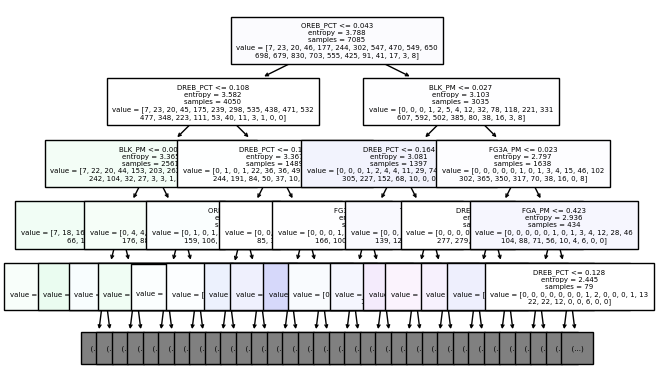

In [33]:
clf_t = DecisionTreeClassifier(random_state=random_state, criterion='entropy', max_depth=grid_search_tree.best_params_['max_depth'], min_samples_split=grid_search_tree.best_params_['min_samples_split'])
clf_t.fit(X_train, y1_train)
y1_pred = clf_t.predict(X_test)
print("Accuracy:", accuracy_score(y1_test, y1_pred))
tree.plot_tree(clf_t, feature_names=X_train.columns, filled=True, fontsize=5, max_depth=4, );

The accuracy is 15%-ish, as seen with other runs.<br>

Expected better, but we guess correctly 1 in 6 times, so it's not "rolling a dice" bad.<br>
As we see, indeed offensive rebounds seem to matter most, followed by defensive rebounds and blocks. Attempts seem to be less relevant, age is "nowhere" (as expected as there is no direct correlation). Let's see how close we usually got to the answer: <br>

Accuracy within 1 inch: 0.42764753435731606
Accuracy within 2 inch: 0.677445432497979
Accuracy within 3 inch: 0.8132578819725141


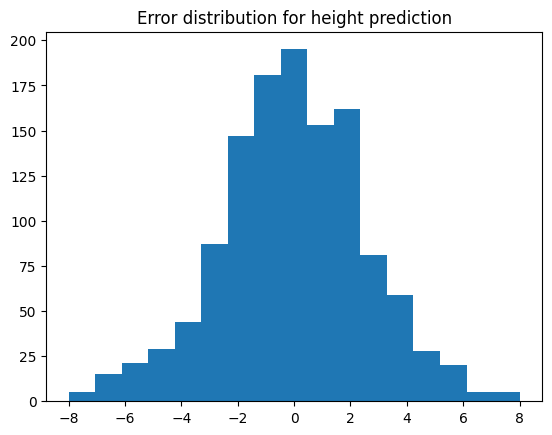

In [34]:
y1_err = y1_test-y1_pred
plt.hist(y1_err, bins=len(y1_err.unique())); plt.title('Error distribution for height prediction')
y1_err_in_1 = y1_err[y1_err.abs()<=1]; y1_err_in_2 = y1_err[y1_err.abs()<=2]; y1_err_in_3 = y1_err[y1_err.abs()<=3]
print("Accuracy within 1 inch:", len(y1_err_in_1)/len(y1_err)); print("Accuracy within 2 inch:", len(y1_err_in_2)/len(y1_err)); print("Accuracy within 3 inch:", len(y1_err_in_3)/len(y1_err))

The result visualized this way is actually much more pleasible. Let's describe what we can see:<br>
Almost 43% of the times we were within 1 inch, and 2 out of 3 times we are within 2 inches, 4 out of 5 times we are within 3 inches. We even did not have an error above 8 inches!I can say, I did not expect this consistency.<br>If we'd categorize the heights into just 3-4 categories, we'd have very good results for predicting each. What I imagined is at least there'd be some rare, but large errors, for a player very tall or very small. (The height span is 69 inches to 90, an interval of length 21 inches.) <br>
To see what made up the predictions, let's see the Shapley values:

#### 1-a-2) SHAP values: Decision tree

The code will run JavaScript to visualize the SHAP values.

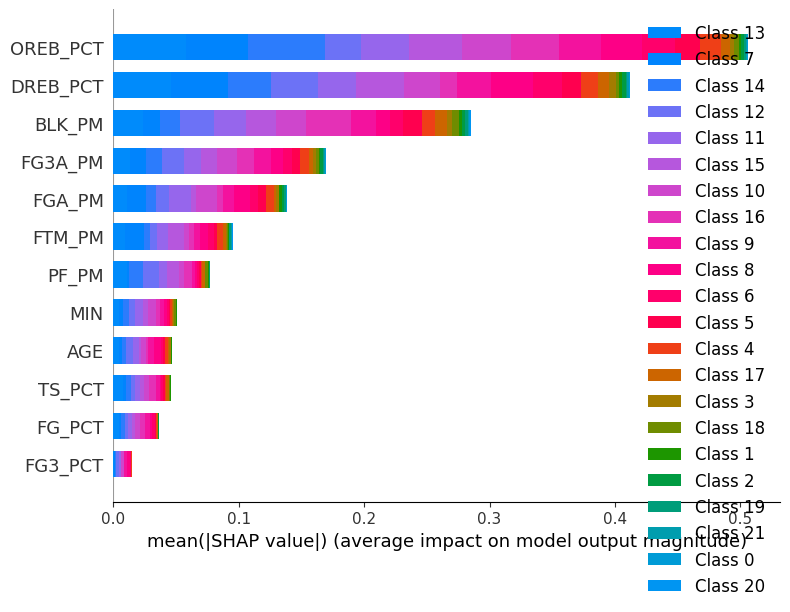

In [46]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(clf_t)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar") #class_names=None, color=single_color where single_color is e.g. matplotlib.colors.CSS4_COLORS['blue']

A bit unorganized plot, let's clean it up:

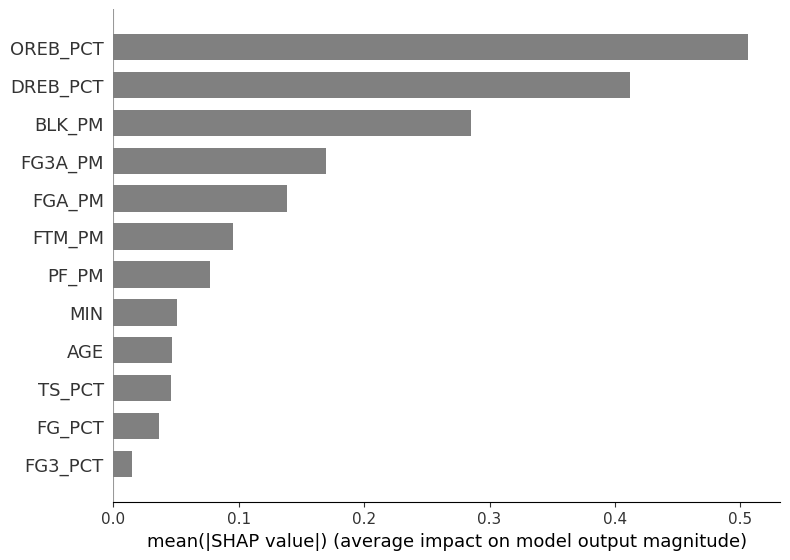

In [48]:
import matplotlib.colors as colors

newcmp = colors.ListedColormap(['grey', 'grey'])

explainer = shap.TreeExplainer(clf_t)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names=None, show=False, color=newcmp)

plt.legend().set_visible(False)
plt.show()

Let's not draw too many conclusions from a tree classifier.<br>
Let's try a random forest with similar parameters:<br>

### 1-b) Random forest classifiers

#### 1-b-1) Random forest (predefined hyperparameters):

In [51]:
clf_f = RandomForestClassifier(n_estimators=100,random_state=random_state, criterion='entropy', max_depth=grid_search_tree.best_params_['max_depth']+3, min_samples_split=grid_search_tree.best_params_['min_samples_split']-10)
clf_f.fit(X_train, y1_train)

RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_split=30,
                       random_state=20001104)

Accuracy: 0.17623282134195634
Accuracy within 1 inch: 0.45270816491511723
Accuracy within 2 inch: 0.7033144704931286
Accuracy within 3 inch: 0.8367016976556184


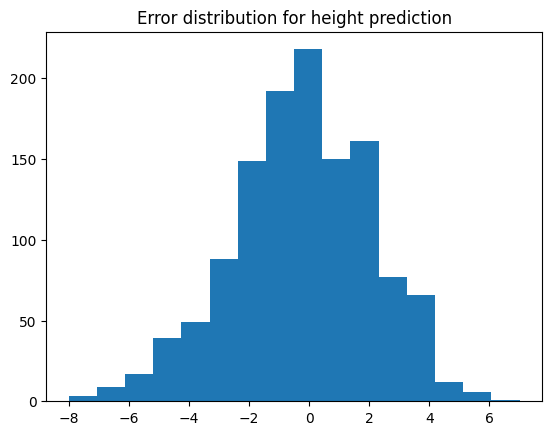

In [52]:
y1_pred_f = clf_f.predict(X_test); y1_err_f = y1_test-y1_pred_f
plt.hist(y1_err_f, bins=len(y1_err_f.unique())); plt.title('Error distribution for height prediction')
y1_err_in_1_f = y1_err_f[y1_err_f.abs()<=1]; y1_err_in_2_f = y1_err_f[y1_err_f.abs()<=2]; y1_err_in_3_f = y1_err_f[y1_err_f.abs()<=3]
print("Accuracy:", accuracy_score(y1_test, y1_pred_f)); print("Accuracy within 1 inch:", len(y1_err_in_1_f)/len(y1_err_f)); print("Accuracy within 2 inch:", len(y1_err_in_2_f)/len(y1_err_f)); print("Accuracy within 3 inch:", len(y1_err_in_3_f)/len(y1_err_f))

Interesting, how we rarely predict 1 inch higher than the player's height (as compared to 1 inch below), instead we predict 2 inches higher more frequently. This happens with other seeds (runs) too.<br> This information will inspire us later (FYI).

In all measures, the forest performs 1.5-3% better than the tree itself. <br>

What is surprising is that the number of +2 errors increased (whilst the number of +1 errors decreased). It shouldn't be like this, probably if using weights (and give more weight to the picked decision tree) this part could be improved a bit. Also, apart from 3 cases, we are in the (-7,+6) range - it is still suprising how close we can get almost every time.

#### 1-b-2) SHAP values for the forest

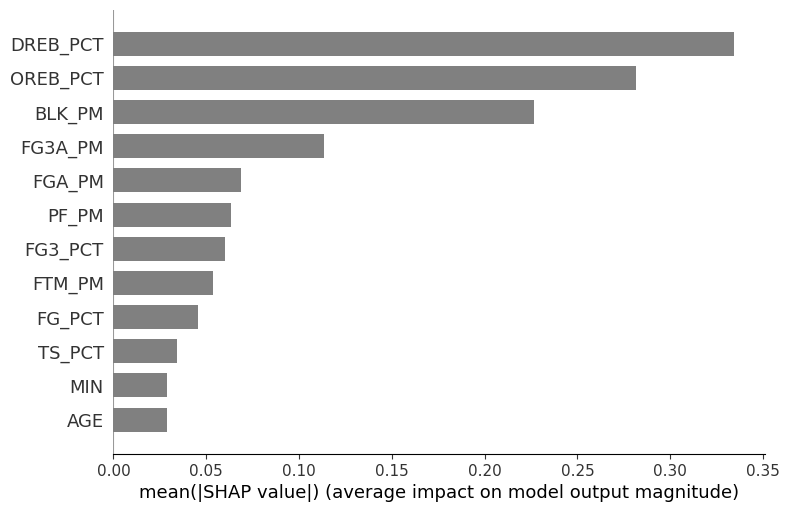

In [53]:
explainer = shap.TreeExplainer(clf_f) #works with forest too
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names=None, show=False, color=newcmp)

plt.legend().set_visible(False)
plt.show()

We see from the forest, which "averages the result" of multiple trees, bringing a more consistent result, that now age, minutes (after correction) do not matter directly in the prediction. This goes rightly with our expectations and shows that these models cannot unlock the potential of indirect relationships (e.g. age mattering in performance, performance predicting height).<br>

We also see that rebounds seem to be the best predictors, which shows well from our analysis plots from before.<br>

### 1-c) Ensemble forest
For the last bit, to enable better prediction with bias, I write an ensemble forest class, to create a manually ensembled forest for improving the results:

#### 1-c-1) Class for ensemble forests:

It's quite ugly to put a class in this notebook and not a separate file/module, but this is for representation.

This is inspired by examples from the sklearn documentation. <br>

In [62]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import random

class LimitedForest(BaseEstimator, ClassifierMixin):

    def __init__(self, number_of_trees=10, features_subset=0.7, instances_subset=0.8, random_seed=42, max_depths=None, min_splits=2 ):
        self.number_of_trees = number_of_trees
        self.instances_subset = instances_subset
        self.random_seed = random_seed
    
        random_seeds = np.random.randint(1,100,number_of_trees)  #For having different seeds for each tree, when creating multiple trees

        self.base_classifiers = []
        for i in range(number_of_trees):
            np.random.seed(random_seeds[i]) #Random.choice has no seed, so had to do this
            max_depth = random.choice(max_depths)
            min_samples_split = random.choice(min_splits)
            self.base_classifiers.append(DecisionTreeClassifier(max_features=features_subset, max_depth=max_depth, min_samples_split=min_samples_split, random_state=random_seed))
        pass
                
    def fit(self, X, y):
        #X: training data, y: target labels
        np.random.seed(self.random_seed)
        for clf in self.base_classifiers:
            X_subset = np.empty((0,len(X[0])))
            y_subset = np.empty((0))
            js = list(range(len(X))) #All possible indices
            for i in range(int(len(X)*0.8)):
                j = random.choice(js) #tried t= np.random.choice(X) too, but requires an if in X_subset re-looping
                js.remove(j) #This way we don't resample
                X_subset = np.append(X_subset, X[j])
                y_subset = np.append(y_subset, y[j])
                #i += 1 #C-style for-loop
            X_subset = X_subset.reshape(int(len(X)*0.8),len(X[0]))
            clf.fit(X_subset,y_subset)
        pass

    def predict(self, X):        
        # X is the unlabaled data, the classifier should return a prediction for each instance in X
        # Get a prediction from each tree
        if self.base_classifiers == []: #just in case
            raise ValueError("No proper fitting was done")
            return []
        
        np.random.seed(self.random_seed)
        modes = [] #Will collect the modes for each data row, of predictions. Decided not to store these in self.___ as they are input-dependent
        for _ in range(len(X)):
            predictions = [] #"Reset"
            for clf in self.base_classifiers:
                predictions.append(int(clf.predict(X[_].reshape(1,-1))[0]) ) #reshape returns a 1D array of 1 element, [0] is for the scalar
            bins = np.bincount(predictions) #Assuming that the predictions are integers, which works here but can be problematic in other use cases
            modes.append(np.argmax(bins))
        return modes

    def predict_proba(self,X): #Unused
        if self.base_classifiers == []:
            print("No proper fitting was done")
            return []

        np.random.seed(self.random_seed)
        probs = []
        for _ in range(len(X)):
            predictions = [] #"Reset"
            for clf in self.base_classifiers:
                predictions.append(int(clf.predict(X[_].reshape(1,-1))) )            
            pred = np.bincount(predictions)/self.number_of_trees
            while len(pred) < 3:
                pred = np.append(pred, 0) #If no prediction for class 2 or 3, then it's only [10] instead of [10,0,0], similarly [x,10-x] instead of [x,10-x,0]
            probs.append(pred)
        return probs

    def predict_avg(self, X):        
        # X is the unlabaled data, the classifier should return a prediction for each instance in X
        # Get a prediction from each tree
        if self.base_classifiers == []: #just in case
            print("No proper fitting was done")
            return []
        
        np.random.seed(self.random_seed)
        avgs = [] #Will collect the modes for each data row, of predictions. Decided not to store these in self.___ as they are input-dependent
        for _ in range(len(X)):
            predictions = [] #"Reset"
            for clf in self.base_classifiers:
                predictions.append(int(clf.predict(X[_].reshape(1,-1))[0]) ) #.tolist() doesn't work, Copilot suggested .reshape(1,-1). Gives warning based on numpy version
            avg = np.average(predictions) #above I assumed that the predictions are integers, not so "nice"
            avg_rounded = round(avg)
            avgs.append(avg_rounded)
        return avgs

#### 1-c-2) Using the ensemble forest:

Set the parameters and fit the data:

Accuracy: 0.15521422797089734
Accuracy within 1 inch: 0.4494745351657235
Accuracy within 2 inch: 0.7025060630557801
Accuracy within 3 inch: 0.8302344381568311


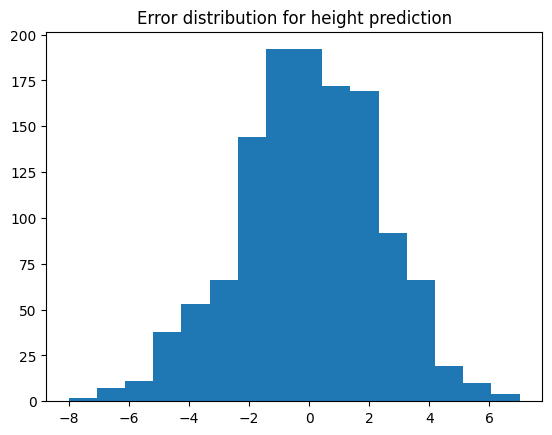

In [63]:
#NBA Forest parameters:
max_depths =list(range(7,12)) +  list(range(5,21))+ [9, 25,30,40] #I added the 7-11 range twice and 9 thrice, to increase their probability of selection
min_splits = [5,10, 15, 20, 24, 30, 35, 40] 

clf_e = LimitedForest(max_depths=max_depths, min_splits=min_splits, random_seed=random_state)
clf_e.fit(X_train.to_numpy(), y1_train.to_numpy())

y1_pred_e = clf_e.predict(X_test.to_numpy() )

print("Accuracy:", sum(y1_pred_e == y1_test)/len(y1_test)); y1_err_e = y1_test-y1_pred_e; 
plt.hist(y1_err_e, bins=len(y1_err_e.unique())); plt.title('Error distribution for height prediction')
y1_err_in_1_e = y1_err_e[y1_err_e.abs()<=1]; y1_err_in_2_e = y1_err_e[y1_err_e.abs()<=2]; y1_err_in_3_e = y1_err_e[y1_err_e.abs()<=3]
print("Accuracy within 1 inch:", len(y1_err_in_1_e)/len(y1_err_e)); print("Accuracy within 2 inch:", len(y1_err_in_2_e)/len(y1_err_e)); print("Accuracy within 3 inch:", len(y1_err_in_3_e)/len(y1_err_e))

It does "mixed". Accuracy around 15.0-17.0% through all runs, 1-inch range accuracy is consistently ~70%.

We saw that there is relatively high +-1 inch error in all models so far. Usually what would rather happen is at least 2x less frequent counts by increasing the error.<br> This suggests to me an "**averaging height predictions**", maybe the 1-over/1-lower guesses will somewhat cancel each other out, there are so high amounts of them that it may have a more positive impact than negative.<br>I already implemented it above, let's try it out (saving an average run):

Accuracy: 0.16248989490703314
Accuracy within 1 inch: 0.49070331447049315
Accuracy within 2 inch: 0.713823767178658
Accuracy within 3 inch: 0.8544866612772838


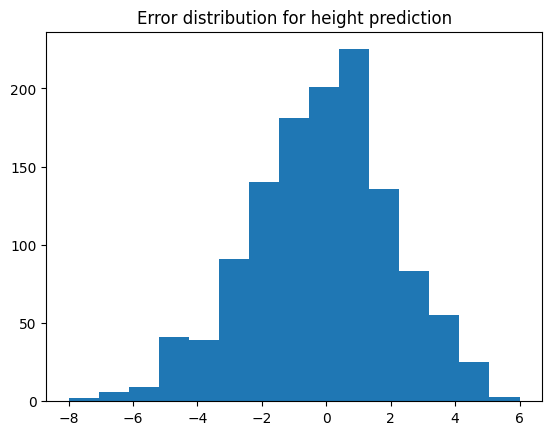

In [64]:
y1_pred_e2 = clf_e.predict_avg(X_test.to_numpy() )
y1_err_e2 = y1_test-y1_pred_e2; y1_err_in_1_e2 = y1_err_e2[y1_err_e2.abs()<=1]; y1_err_in_2_e2 = y1_err_e2[y1_err_e2.abs()<=2]; y1_err_in_3_e2 = y1_err_e2[y1_err_e2.abs()<=3]
plt.hist(y1_err_e2, bins=len(y1_err_e2.unique())); plt.title('Error distribution for height prediction')
print("Accuracy:", sum(y1_pred_e2 == y1_test)/len(y1_test));print("Accuracy within 1 inch:", len(y1_err_in_1_e2)/len(y1_err_e2)); print("Accuracy within 2 inch:", len(y1_err_in_2_e2)/len(y1_err_e2)); print("Accuracy within 3 inch:", len(y1_err_in_3_e2)/len(y1_err_e2))

Surprisingly 

- the "perfect accuracy" only increased to 16%,
- we see a shift towards much more to +1 errors (further suprising that we have more +1 errors than correct guesses),

However,

- the **+-1 inch accuracy is the highest by far** among all models, +-2 and +-3 inch accuracy is also the highest. 

Safe to say, this is the best guesser method so far; and it can be "tricked" into better perfect guess by choosing a 1-higher guess than the average. (Of course, implementing a model that guesses exactly 1 less than this model would be a hack/cheat.)

Trying with different values it does indeed vary quite a lot. I occasionally got 17+% for perfect accuracy, but the **+-1 inch accuracy is always the highest at ~49%**. As the perfect accuracy is lower for the simple ensembler predict, the average is near the highest, suprisingly. The "+1 bias" is indeed consistently happening, interestingly.<br>

Being honest, I expected better "perfect accuracy", but the +-1 inch accuracy is also much better than expected.<br>
It's just surprising that we guess 1 inch lower/higher 16-17% of the times, just like guessing the correct height (16+16+17=49). You'd think that they'd split rather like 22-11-11 or so.<br>

### 1-d) Comparison of classifiers + regression (random forest)

Lastly, motivated by the averaging ensembler, not a classifier but it'd be interesting to see how well a random forest regressor could perform:

*Note*: The regressor isn't outputting integers, so we have to round the results. <br>

Accuracy within 1 inch: 0.5004042037186742
Accuracy within 2 inch: 0.7291835084882781
Accuracy within 3 inch: 0.8641875505254648


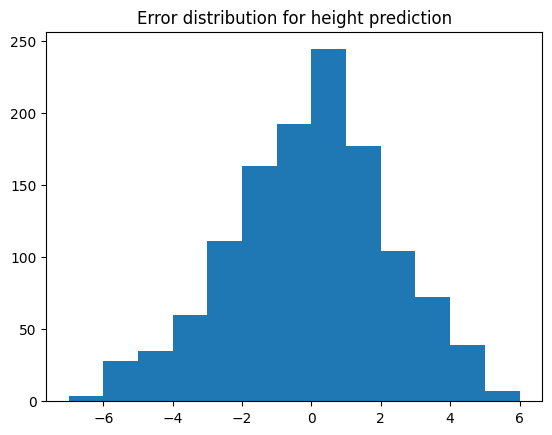

In [65]:
clf_r = RandomForestRegressor(n_estimators=100,random_state=random_state, criterion='squared_error', max_depth=10, min_samples_split=25)
clf_r.fit(X_train, y1_train)

y1_pred_r =clf_r.predict(X_test)

y1_err_r = y1_test-y1_pred_r
plt.hist(y1_err_r, bins=range(int(np.floor(np.min(y1_err_r))), int(np.floor(np.max(y1_err_r))) + 1, 1)); plt.title('Error distribution for height prediction')
y1_err_in_1_r = y1_err_r[y1_err_r.abs()<1.5]; y1_err_in_2_r = y1_err_r[y1_err_r.abs()<2.5]; y1_err_in_3_r = y1_err_r[y1_err_r.abs()<3.5]
print("Accuracy within 1 inch:", len(y1_err_in_1_r)/len(y1_err_r)); print("Accuracy within 2 inch:", len(y1_err_in_2_r)/len(y1_err_r)); print("Accuracy within 3 inch:", len(y1_err_in_3_r)/len(y1_err_r))

Without rounding it would do worse, however with rounding it is our **best model** with just above **50% +-1 inch accuracy, ~73% +-2 inch accuracy, and ~86% +-3 inch accuracy**.<br>

**Note**:Here the plot is a bit deceiving, because we'd think that the +1 error is still present, but the binning is plotted different, shifted to the right, so the highest bin is the between 0 and over 1 inch error. 

Let's conclude our results:

| Model                        | Accuracy Score | +/-1 inch % | +/-2 inch % | +/-3 inch % | Error Range |
|------------------------------|----------------|-------------|-------------|-------------|-------------|
| Decision tree                | 15.7%         | 42.8%       | 67.7%       | 81.3%       | -8,7        |
| Random forest classifier     | **17.6%**          | 45.3%       | 70.3%       | 83.7%       | -8,6        |
| Ensemble forest 1            | 15.5%          | 44.9%       | 70.2%       | 83.0%       | -8,6        |
| Ensemble forest averaging    | 16.2%          | **49.0%**       | **71.3%**       | **85.4%**       | -8,5        |
| Random forest regressor      | -              | **50.0%**   | **72.9%**       | **86.4%**       | **-7,5**        |

## 2) Clustering

**Height given a larger weight than other attributes**

I cluster the players together, giving big importance to height, and see what is common in the clusters. <br>
Here I drop the age attribute, but will look into it aswell. My plan is to cluster players into some groups, and see the averages of the attributes in the groups. <br>

### 2-a) Normalizing the data:

Before I normalize, let's see the "scale" of some attributes. <br>
This will help decide if we should normalize some attributes differently (e.g. by logaritmizing them).<br>

Our goal is to put all attributes on the same scale, so that any outlying values have the same importance in the clustering. <br>

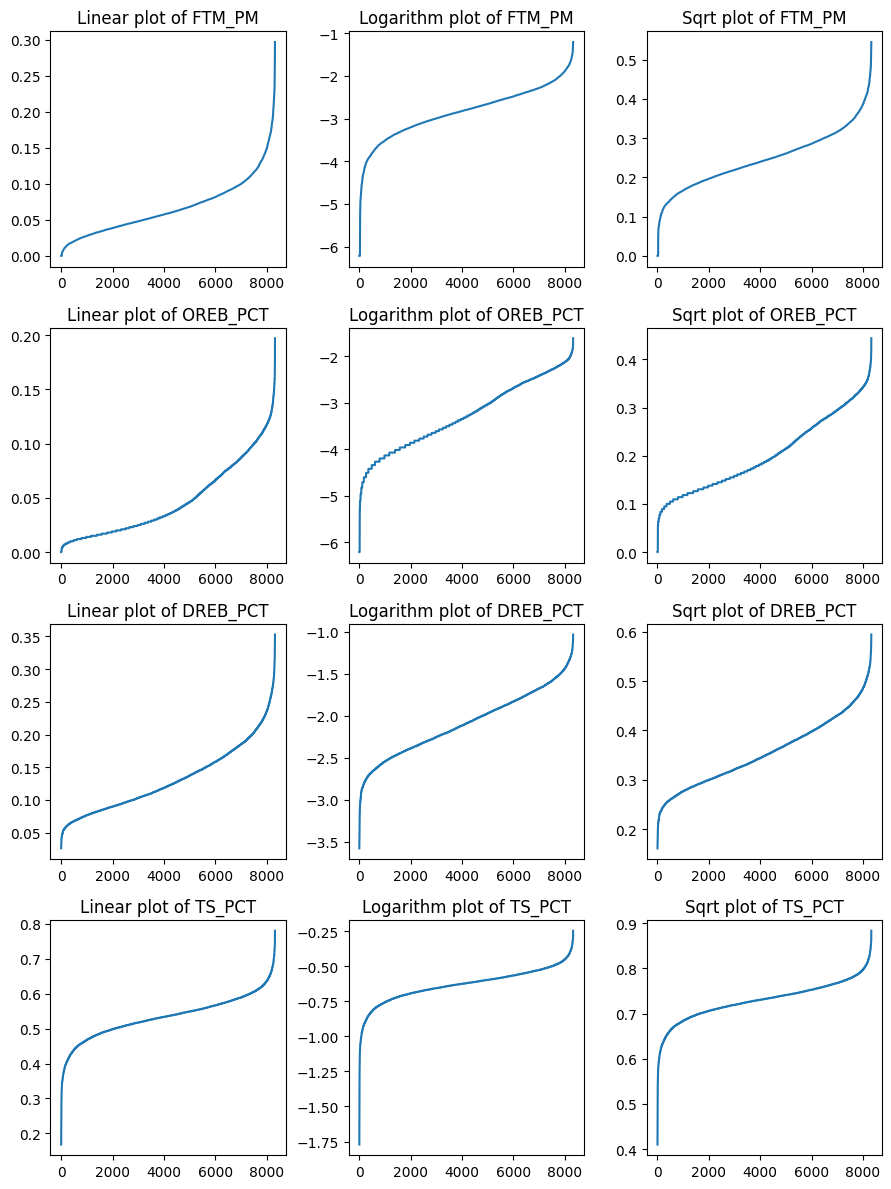

In [70]:
plotting.plot_in_rows([data['FTM_PM'], data["OREB_PCT"], data["DREB_PCT"], data["TS_PCT"]], ["FTM_PM", "OREB_PCT", "DREB_PCT", "TS_PCT"])

For rebounds, logarithmic seems like a good choice.

TS_PCT looks like an inverse of a sigmoid function. Let's try then applying this function on the values to hopefully get something linear:<br>

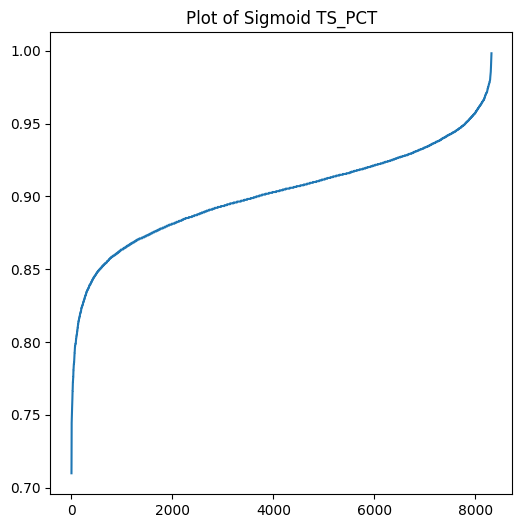

In [71]:
sigmoid_ts_pct = (1/(np.power(data["TS_PCT"], 3.6) +1)); # max = np.max(sigmoid_ts_pct); min = np.min(sigmoid_ts_pct);
#sigmoid_ts_pct_normalized = [(v-min)/(max-min) for v in sigmoid_ts_pct]
plotting.plot_ordered(sigmoid_ts_pct, "Sigmoid TS_PCT")
#plot_ordered(sigmoid_ts_pct_normalized, "Normalized Sigmoid TS_PCT")

It is something better, but not by much. So I will just keep it as it is, and not normalize it by some function.<br>
I saw curves similar to this be modeled with "Logarithmic Companding Curves", namely the μ-law and A-law curves - but it's not worth it to invest the time into it. Might also be bad plotting, should plot things possibly not by (sorted) index. Also should have adjusted to the axis intersection value 1/2. <br>
https://www.allaboutcircuits.com/technical-articles/companding-logarithmic-laws-implementation-and-consequences/

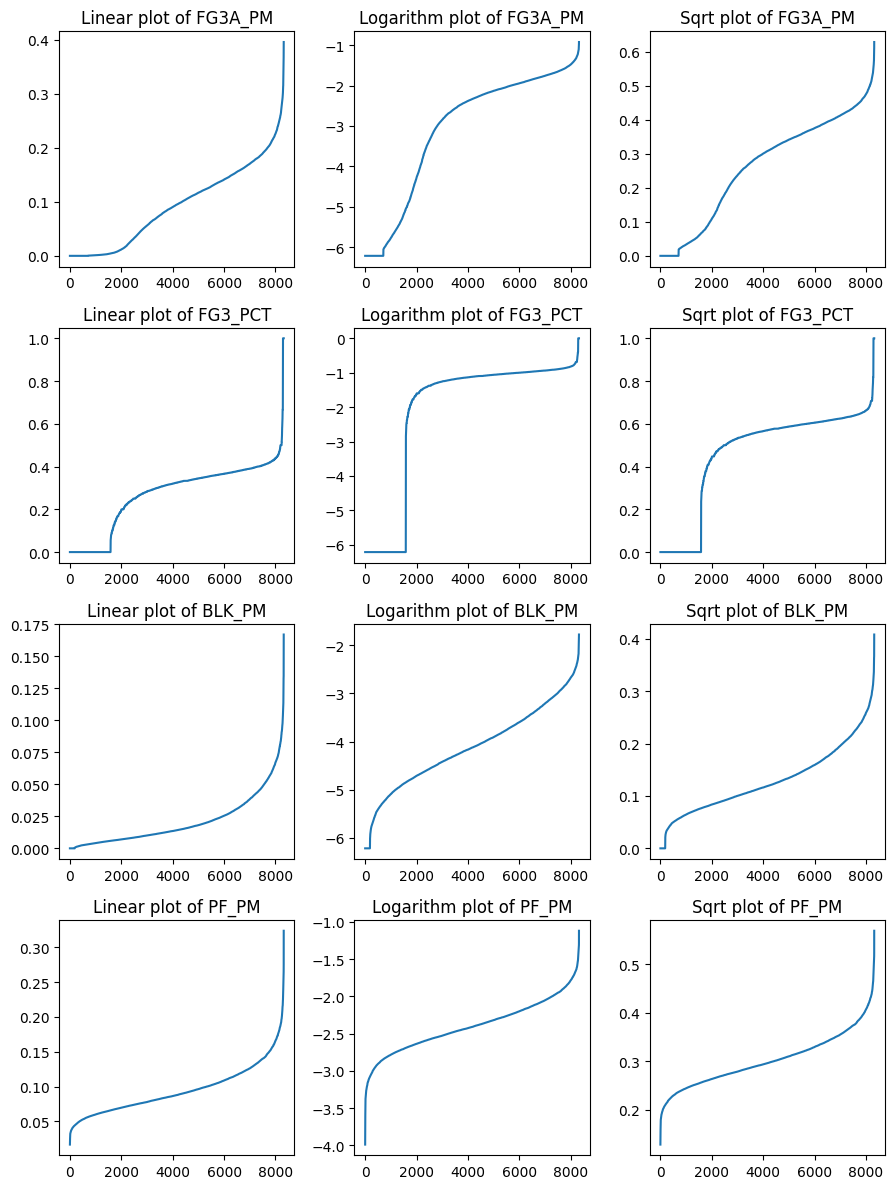

In [73]:
plotting.plot_in_rows([data["FG3A_PM"],data["FG3_PCT"],data["BLK_PM"],data["PF_PM"]], ["FG3A_PM", "FG3_PCT", "BLK_PM", "PF_PM"])

**3-pointer assists:** Interesting values, never seen anything like this. Assumably the square root plot is the most linear. Square root normalization.<br>
**3-pointers:** Makes sense that there are many zeros, but overall weird looking. If not normalizing (first case), 0 and 1 values would cluster together because everything else varies too much from them - in the second and third one, only the 0 values would cluster. I cannot keep this as it is, so I'm afraid it has to be dropped for clustering. <br>
**Blocks per minute:** Logarithmic normalization looks good (middle plot). <br>
**Personal fouls:** Keeping it as it is.<br>

Now, we can proceed and prepare the data:

In [75]:
cluster_X = data.drop(columns=['SEASON_ID','PLAYER_WEIGHT', 'MIN','AGE', 'FG3_PCT'])
log_columns= ['FTM_PM', 'OREB_PCT', 'DREB_PCT', 'BLK_PM']
for column in log_columns:
    cluster_X[column] = [np.log(val+0.002) for val in cluster_X[column]]
cluster_X['FG3A_PM'] =  [np.sqrt(val+0.000001) for val in cluster_X['FG3A_PM']]
cluster_X = cluster_X.rename(columns={'FTM_PM': 'LOG_FTM_PM','OREB_PCT': 'LOG_OREB_PCT','DREB_PCT': 'LOG_DREB_PCT', 'BLK_PM': 'LOG_BLK_PM', 'FG3A_PM': 'SQRT_FG3A_PM'})
cluster_X[cluster_X.columns[1:]] = (cluster_X[cluster_X.columns[1:]]-cluster_X[cluster_X.columns[1:]].min())/(cluster_X[cluster_X.columns[1:]].max()-cluster_X[cluster_X.columns[1:]].min()) #Normalize
cluster_X["PLAYER_HEIGHT_INCHES"] = 2*cluster_X["PLAYER_HEIGHT_INCHES"] #For more weight
cluster_X

,PLAYER_ID,PLAYER_HEIGHT_INCHES,LOG_OREB_PCT,LOG_DREB_PCT,TS_PCT,FGA_PM,FG_PCT,SQRT_FG3A_PM,LOG_FTM_PM,LOG_BLK_PM,PF_PM
0,1630639,1.04,0.690858,0.671184,0.687908,0.558371,0.792018,0.762919,0.464075,0.0,0.276083
1,1631260,0.96,0.477641,0.527823,0.71732,0.491922,0.474501,0.877053,0.3827,0.0,0.238588
2,203932,1.2,0.822622,0.627994,0.73366,0.50422,0.660754,0.46052,0.77082,0.585211,0.150502
3,1628988,0.56,0.588686,0.306573,0.588235,0.335126,0.466519,0.512384,0.565478,0.471598,0.250415
4,1630174,0.96,0.622196,0.576235,0.650327,0.434365,0.478492,0.660679,0.70278,0.527085,0.367232
...,...,...,...,...,...,...,...,...,...,...,...
8317,1626195,1.44,0.865119,0.853987,0.666667,0.504759,0.618182,0.384177,0.782507,0.526477,0.223881
8318,201163,1.2,0.452037,0.700726,0.593137,0.318155,0.447894,0.645065,0.535693,0.49966,0.296402
8319,1627812,0.56,0.4069,0.446355,0.588235,0.480232,0.46918,0.613308,0.709742,0.352378,0.17953
8320,1628380,1.44,0.843789,0.663438,0.604575,0.29534,0.537029,0.406078,0.484992,0.510368,0.350099


### 2-b) Clustering, dendrogram

We plot two dendograms (code from the [sklearn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)):

- One with all attributes, to see how the clusters are formed. "Have a feeling".
- One with only the most important attributes, to see how the clusters are formed when height is given a big weight.

In [76]:
from sklearn.cluster import AgglomerativeClustering

X =cluster_X.set_index('PLAYER_ID').values

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)

The first dendogram, marked with a red line for a good cut:

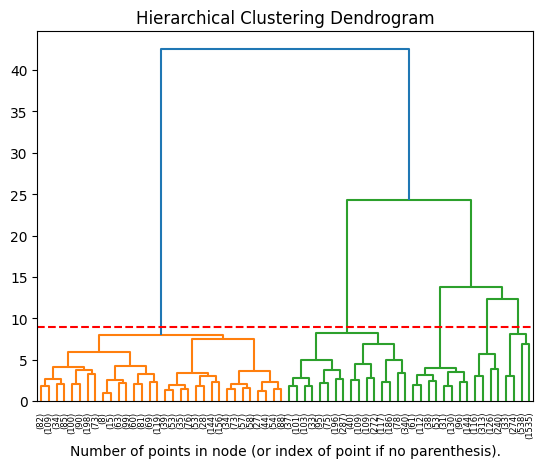

In [77]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top 10 levels of the dendrogram
plotting.plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=9, color='r', linestyle='--') # I chose this threshold afterwards, so I plotted it here
plt.show()

The red line seems to be a good height (value) to cluster from. This creates 5 different clusters.

Group 0 length: 2178 
 Group 1 length: 2304 
 Group 2 length: 2380 
 Group 3 length: 665 
 Group 4 length: 795 



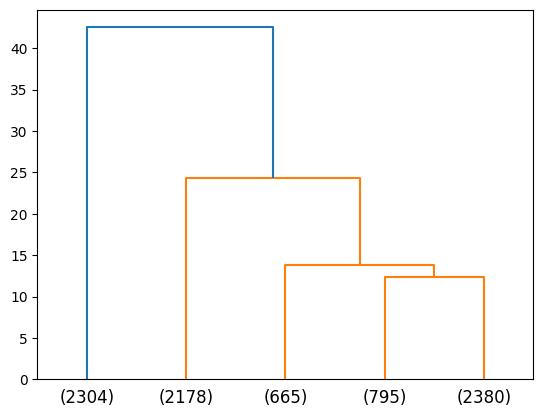

In [78]:
model2 = AgglomerativeClustering(n_clusters=5, compute_distances=True)
model2 = model2.fit(X)
plotting.plot_dendrogram(model2, truncate_mode='lastp', p=5)
print("Group 0 length:", len(data[model2.labels_ == 0]),'\n' ,  
      "Group 1 length:", len(data[model2.labels_ == 1]),'\n' ,  
      "Group 2 length:", len(data[model2.labels_ == 2]),'\n' ,  
      "Group 3 length:", len(data[model2.labels_ == 3]),'\n' ,  
      "Group 4 length:", len(data[model2.labels_ == 4]),'\n' , )

### 2-c) Evaluating the 5 clusters

In [79]:
comparison = data.drop(columns=["PLAYER_ID", "SEASON_ID"])[0:0]
comparison = pd.concat([comparison, (data[model2.labels_ == 0].drop(columns=["PLAYER_ID", "SEASON_ID"]).mean()).to_frame().T], axis=0, ignore_index=True)
comparison = pd.concat([comparison, (data[model2.labels_ == 1].drop(columns=["PLAYER_ID", "SEASON_ID"]).mean()).to_frame().T], axis=0, ignore_index=True)
comparison = pd.concat([comparison, (data[model2.labels_ == 2].drop(columns=["PLAYER_ID", "SEASON_ID"]).mean()).to_frame().T], axis=0, ignore_index=True)
comparison = pd.concat([comparison, (data[model2.labels_ == 3].drop(columns=["PLAYER_ID", "SEASON_ID"]).mean()).to_frame().T], axis=0, ignore_index=True)
comparison = pd.concat([comparison, (data[model2.labels_ == 4].drop(columns=["PLAYER_ID", "SEASON_ID"]).mean()).to_frame().T], axis=0, ignore_index=True)
comparison

,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,OREB_PCT,DREB_PCT,TS_PCT,MIN,FGA_PM,FG_PCT,FG3A_PM,FG3_PCT,FTM_PM,BLK_PM,PF_PM
0,27.151974,74.698347,193.802571,0.018574,0.084973,0.520873,1574.474288,0.339305,0.41656,0.123209,0.338609,0.063738,0.006211,0.077583
1,26.812934,82.277778,247.46441,0.090697,0.180128,0.544796,1346.690972,0.283458,0.508876,0.007535,0.106412,0.069336,0.039358,0.122713
2,26.741176,78.979412,217.617647,0.03462,0.118832,0.524461,1397.513445,0.297171,0.423767,0.11791,0.324747,0.04881,0.015024,0.087824
3,26.584962,82.369925,239.308271,0.05874,0.176638,0.551629,1598.27218,0.379285,0.457068,0.123768,0.336471,0.077632,0.032896,0.100516
4,26.432704,77.444025,210.74717,0.025161,0.115992,0.552738,2098.29434,0.463905,0.443975,0.160244,0.351097,0.109838,0.013649,0.071753


Let's evaluate the 5 groups:<br>
Dendogram: Group 1 is the most disassociated group. Groups 2, 3, 4 are (in comparison) fairly "similar", Group 0 is also quite disassociated. <br>
**Age**: Mostly similar. Seems like it did not matter indeed.<br>
**Height, Weight**: Group 1 and 3 are the big guys (height similar, group 1 is a bit heavier), group 0 is lightweight, group 2 and 4 are medium. Group 4 is also somewhat more in the lighter category. <br>
**Rebounds**: We can indeed see that the two "big" groups have substantially more rebounds than the other groups. What makes a difference is that whilst their defensive rebound percentages are quite similar, the offensive ones are not: the big big group (group 1) has more than 150% of offensive rebounds compared to the group 3.<br>
**Shooting percentage**: Nearly similar with the exception that small guys and group 2 does a little less well.<br>
**Minutes**: Group 4 plays a lot, much more than other groups. The big big guys play the least, along with group 2. Little guys and group 3 play similarly much. <br>
**FGA_PM**: Group 4 has exceptional stats. Group 1 and 2 do the least, small guys also do not try much. <br>
**FG_PCT**: Small guys and group 2 do worst, the big big guys stand out. Group 4 do almost as well as group 3. <br>
**FG3A_PM**: Group 4 does the most by quite an amount, small guys do as much as group 3, I expected more from them. But the big big guys almost never throw a 3-pointer. I highly assume they are players from one position, that is close to the basket. <br>
**FG3_PCT**: Similar statistics to all groups except the big big guys. <br>
**FTM_PM**: Group 4 does best again, and group 2 do worst. <br>
**BLK_PM**: The big guys block most, small guys almost never, once every 160 minutes. <br>
**PF_PM**: The big guys foul the most but considerably low amounts, group 4 does best. <br>

### 2-d) Takeaway


- The cluster analysis actually separated fairly closely to positions. Big big guys are surely centers, group 3 are power forwards, and small guys are supposed to be the point guards.
- However, since point guards, shooting guards and small fowards (remaining positions) are so versatile that the cluster algorithm separated thse players into rather "small guys, bad and good players" from what I see. <br>

## 3) Prediction: Gradient descent

A model like gradient descent helps us not overfit, and enables using indirect relations for prediction. 

I'd believe gradient descent is very sensitive for loty of local minima, so I will drop personal fouls, age, and TS_PCT for the first runs.

There are methods that are more robust to local minima, so it is worth trying full data too; see if we get benefits from age and other less directly related attributes. Probably `xgboost` would be a great choice for such method.


In [81]:
X = train.drop(columns=["PLAYER_ID", "SEASON_ID","PLAYER_HEIGHT_INCHES", "PLAYER_WEIGHT", "MIN", "AGE", "PF_PM", "TS_PCT"]); X_t = test.drop(columns=["PLAYER_ID", "SEASON_ID","PLAYER_HEIGHT_INCHES", "PLAYER_WEIGHT", "MIN", "AGE", "PF_PM", "TS_PCT"])
y = train["PLAYER_HEIGHT_INCHES"]; y_t = test["PLAYER_HEIGHT_INCHES"]
X

,OREB_PCT,DREB_PCT,FGA_PM,FG_PCT,FG3A_PM,FG3_PCT,FTM_PM,BLK_PM
0,0.040,0.153,0.469248,0.435,0.186333,0.342,0.109339,0.011845
1,0.015,0.082,0.307997,0.481,0.082344,0.452,0.017419,0.014252
2,0.096,0.268,0.493126,0.559667,0.043996,0.29,0.134739,0.048579
3,0.025,0.075,0.246696,0.429,0.202643,0.413,0.136564,0.004405
4,0.013,0.067,0.282251,0.370667,0.064069,0.368,0.034632,0.0
...,...,...,...,...,...,...,...,...
7080,0.013,0.108,0.339419,0.399,0.126971,0.373,0.030705,0.024066
7081,0.020,0.102,0.422075,0.436,0.096386,0.339,0.101827,0.007384
7082,0.055,0.152,0.200637,0.465333,0.0,0.0,0.047771,0.025478
7083,0.046,0.145,0.260927,0.376,0.178808,0.37,0.029139,0.019868


### 3-a) Without hyperparameter tuning (Gradient boosted classifier)

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
clf_g = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=0)
clf_g.fit(X, y)
clf_g.score(X_t, y_t)

0.1576394502829426

Accuracy: 0.1576394502829426
Accuracy within 1 inch: 0.4413904607922393
Accuracy within 2 inch: 0.6645109135004043
Accuracy within 3 inch: 0.8124494745351657


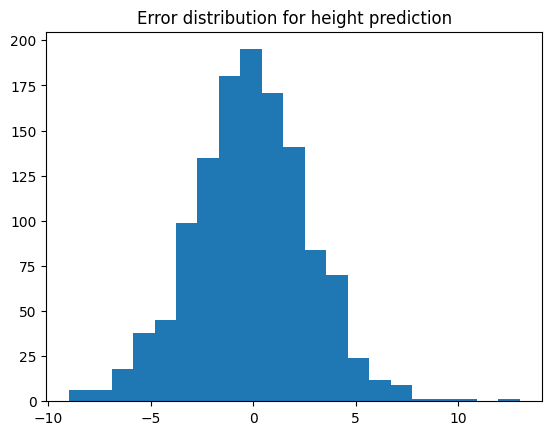

In [83]:
y_pred_g = clf_g.predict(X_t); y_err_g = y_t-y_pred_g; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=len(y_err_g.unique())); plt.title('Error distribution for height prediction')
print("Accuracy:", accuracy_score(y_t, y_pred_g)); print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

With just simple dummy estimators (and 1 layer depth), we get 15.76% accuracy, roughly the same as before. <br>
How about without depth restriction? <br>

In [84]:
clf_g = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, random_state=20001104)
clf_g.fit(X, y)
clf_g.score(X_t, y_t)

0.14551333872271624

Wow, it did worse! Okay, fine.<br>

How about the original data? The data that all other models were given, not dropping age and other attributes.

In [85]:
clf_g = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, random_state=20001104)
clf_g.fit(X_train, y1_train)
clf_g.score(X_test, y1_test)

0.1713823767178658

Seems that using the full data increases results. We will stick with full data only.

Accuracy: 0.1713823767178658
Accuracy within 1 inch: 0.44543249797898143
Accuracy within 2 inch: 0.6491511721907841
Accuracy within 3 inch: 0.7890056588520614


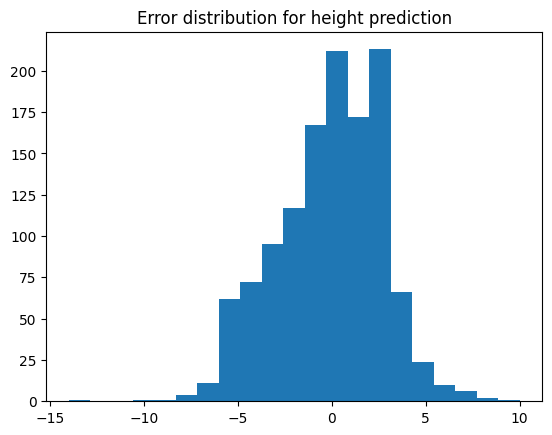

In [86]:
y_pred_g = clf_g.predict(X_test); y_err_g = y1_test-y_pred_g; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=len(y_err_g.unique())); plt.title('Error distribution for height prediction')
print("Accuracy:", accuracy_score(y1_test, y_pred_g)); print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

It did better for simple accuracy, it is the highest accuracy score so far. But in comparison to the forests, it's worse in all other metrics, notably in error range.<br>
We note these results.

### 3-b) Hyperparameter tuned classifier

May even use a previous classifier as a starting point. (clf_e has does not work here, incomplete class design)<br>

Let's do that, change parameters a bit. I base them off of https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html. There is time to compute - I'll try subsample. I do not think we need many estimators as we have not too many rows of data and not too many features - but there is time to compute. 

But first, hyperparameter tuning (said to be important for gradient descent)

**WARNING**: This computation took over **50 hours**, 3014 minutes!! If you run it, check n_jobs, consider setting it to -1. (Also consider a different cross-validation algorithm, than GSCV).<br>

In [366]:
booster_params = {
    'n_estimators': [350, 750, 1000, 2000],
    'max_features': [None,"sqrt"],
    'max_depth': [10,15, 22, None], 
    'subsample': [0.5, 1.0],
    }
boost_null = GradientBoostingClassifier(random_state=20001104, learning_rate=0.2)

# Perform Grid Search Cross-Validation
gs_cv_booster2 = GridSearchCV(estimator=boost_null, param_grid=booster_params,)
gs_cv_booster2.fit(X_train, y1_train)
print("Best Hyperparameters: ", gs_cv_booster2.best_params_)

The least populated class in y has only 3 members, which is less than n_splits=5.


Best Hyperparameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 350, 'subsample': 1.0}


Interestingly, number of estimators got the lowest value. We'll see how it performs.

Fit the new classifier based on best hyperparameters:

Accuracy: 0.13500404203718674
Accuracy within 1 inch: 0.4082457558609539
Accuracy within 2 inch: 0.6515763945028294
Accuracy within 3 inch: 0.793856103476152


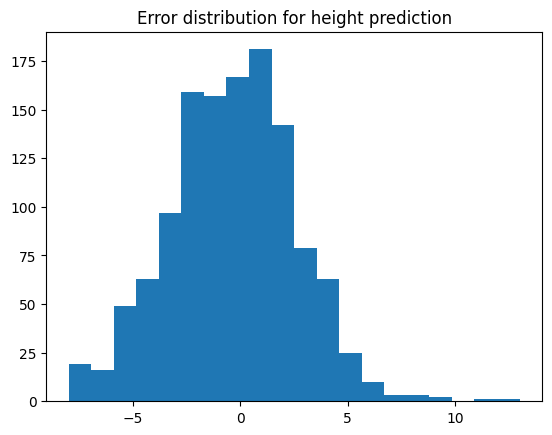

In [103]:
clf_g1 = gs_cv_booster2
y_pred_g1 = clf_g1.predict(X_test); y_err_g = y1_test-y_pred_g1; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=len(y_err_g.unique())); plt.title('Error distribution for height prediction')
print("Accuracy:", accuracy_score(y1_test, y_pred_g1)); print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

This is very poor accuracy in all counts. Likely, we need higher estimator number, 350 might not be enough.<br>
Add 3000 more iterations:

The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy: 0.13823767178658045
Accuracy within 1 inch: 0.40905416329830235
Accuracy within 2 inch: 0.6556184316895716
Accuracy within 3 inch: 0.793856103476152


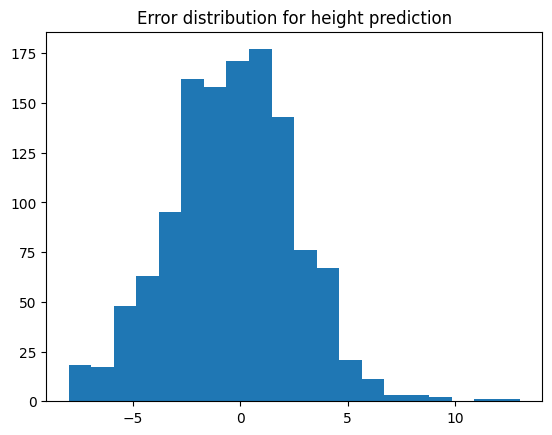

In [104]:
clf_g2 = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.2, max_depth=10,
                                    max_features = 'sqrt', subsample= 1.0, random_state=20001104,
                                    init=clf_g1)
clf_g2.fit(X_train, y1_train)
y_pred_g2 = clf_g2.predict(X_test); y_err_g = y1_test-y_pred_g2; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=len(y_err_g.unique())); plt.title('Error distribution for height prediction')
print("Accuracy:", accuracy_score(y1_test, y_pred_g2)); print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

There is almost a percent increase, and seems that the model is still learning (I assume from the plot).<br>
But after such amount of calculations, to see disappointing results, it is not worth it to continue.<br>

We can immediately try two things:

- initialize with other models (e.g. a forest)

- change parameters

Let's first try the latter one, with features more similar to the forest models:

The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy: 0.15198059822150364
Accuracy within 1 inch: 0.41632983023443815
Accuracy within 2 inch: 0.6572352465642683
Accuracy within 3 inch: 0.7930476960388035


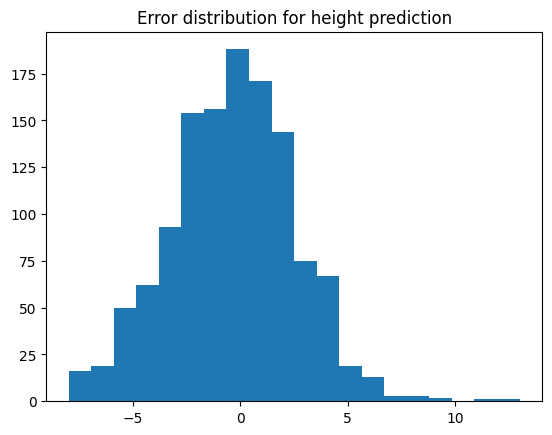

In [105]:
clf_g3 = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.2, max_depth=15,
                                    max_features=None, subsample=0.5 , random_state=20001104,
                                    init=clf_g2)
clf_g3.fit(X_train, y1_train)
clf_g3.score(X_test, y1_test)
y_pred_g3 = clf_g3.predict(X_test); y_err_g = y1_test-y_pred_g3; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=len(y_err_g.unique())); plt.title('Error distribution for height prediction')
print("Accuracy:", accuracy_score(y1_test, y_pred_g3)); print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

Now initializing with a forest:

Accuracy: 0.15602263540824576
Accuracy within 1 inch: 0.4349232012934519
Accuracy within 2 inch: 0.6750202101859337
Accuracy within 3 inch: 0.8100242522231205


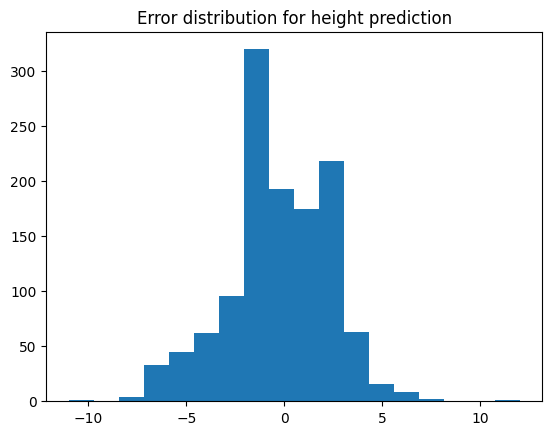

In [108]:
clf_g4 = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.2, max_depth=10,
                                    max_features = 'sqrt', subsample= 1.0, random_state=20001104,
                                    init=clf_f)
clf_g4.fit(X_train, y1_train)
y_pred_g4 = clf_g4.predict(X_test); y_err_g = y1_test-y_pred_g4; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=len(y_err_g.unique())); plt.title('Error distribution for height prediction')
print("Accuracy:", accuracy_score(y1_test, y_pred_g4)); print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

A bit more cocoa:

Accuracy: 0.1576394502829426
Accuracy within 1 inch: 0.4349232012934519
Accuracy within 2 inch: 0.6742118027485853
Accuracy within 3 inch: 0.8132578819725141


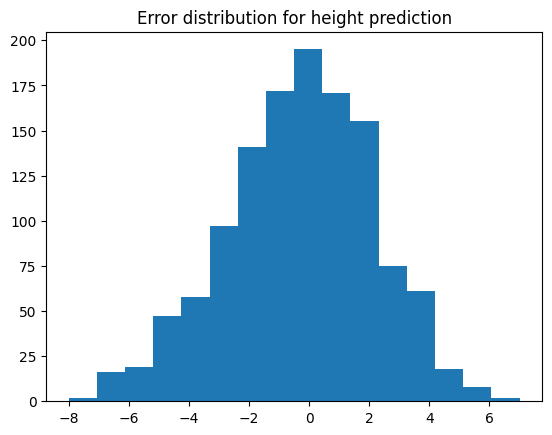

In [109]:
clf_g5 = GradientBoostingClassifier(n_estimators=9000, learning_rate=0.2, max_depth=10,
                                    max_features = 'sqrt', subsample= 1.0, random_state=20001104,
                                    init=clf_g4)
clf_g5.fit(X_train, y1_train)
y_pred_g5 = clf_g5.predict(X_test); y_err_g = y1_test-y_pred_g5; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=len(y_err_g.unique())); plt.title('Error distribution for height prediction')
print("Accuracy:", accuracy_score(y1_test, y_pred_g5)); print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

Both results are better than the previous boosted classifier, but still worse than the forests.<br>
Notably, the boosted classifier which is initializing with the forest reduced its accuracy by around 2%.

We can conclude, that unless very well parameterized, the scikit-learn gradient boosting classifier is not a good choice for this problem.<br>
(It would be worth it to try XGBoost.)

Let's try regression, both with and without initial classifier:
### 3-c) Regression with GradientBoostingRegressor

Results for uninitialized GradientBoostingRegressor:
Accuracy within 1 inch: 0.47453516572352467
Accuracy within 2 inch: 0.6952303961196443
Accuracy within 3 inch: 0.8326596604688763

Results for initialized GradientBoostingRegressor:
Accuracy within 1 inch: 0.4987873888439774
Accuracy within 2 inch: 0.6911883589329022
Accuracy within 3 inch: 0.8447857720291027


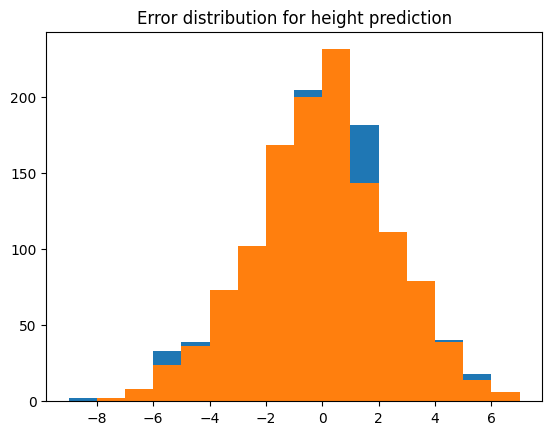

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
clf_g6 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.2, max_depth=10, max_features=None, subsample=0.5 , random_state=20001104, )
clf_g7 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.2, max_depth=10, max_features=None, subsample=0.5 , random_state=20001104, init=clf_r)

clf_g6.fit(X_train, y1_train)
clf_g7.fit(X_train, y1_train)

y_pred_g6 = clf_g6.predict(X_test); y_err_g = y1_test-y_pred_g6; y_err_in_1_g = y_err_g[y_err_g.abs()<1.5]; y_err_in_2_g = y_err_g[y_err_g.abs()<2.5]; y_err_in_3_g = y_err_g[y_err_g.abs()<3.5]
plt.hist(y_err_g, bins=range(int(np.floor(np.min(y_err_g))), int(np.floor(np.max(y_err_g))) + 1, 1)); plt.title('Error distribution for height prediction')
print("Results for uninitialized GradientBoostingRegressor:")
print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

print("\nResults for initialized GradientBoostingRegressor:")
y_pred_g7 = clf_g7.predict(X_test); y_err_g = y1_test-y_pred_g7; y_err_in_1_g = y_err_g[y_err_g.abs()<1.5]; y_err_in_2_g = y_err_g[y_err_g.abs()<2.5]; y_err_in_3_g = y_err_g[y_err_g.abs()<3.5]
plt.hist(y_err_g, bins=range(int(np.floor(np.min(y_err_g))), int(np.floor(np.max(y_err_g))) + 1, 1)); plt.title('Error distribution for height prediction')
print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

We do see better results. Let's continue training from the forest:

Results for initialized GradientBoostingRegressor:
Accuracy within 1 inch: 0.4987873888439774
Accuracy within 2 inch: 0.6911883589329022
Accuracy within 3 inch: 0.8447857720291027


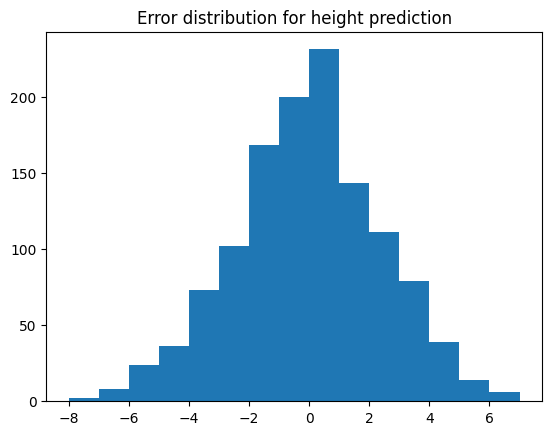

In [113]:
clf_g8 = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.2, max_depth=10, max_features=None, subsample=0.5 , random_state=20001104, init=clf_g7)
clf_g8.fit(X_train, y1_train)

print("Results for initialized GradientBoostingRegressor:")
y_pred_g8 = clf_g8.predict(X_test); y_err_g = y1_test-y_pred_g8; y_err_in_1_g = y_err_g[y_err_g.abs()<1.5]; y_err_in_2_g = y_err_g[y_err_g.abs()<2.5]; y_err_in_3_g = y_err_g[y_err_g.abs()<3.5]
plt.hist(y_err_g, bins=range(int(np.floor(np.min(y_err_g))), int(np.floor(np.max(y_err_g))) + 1, 1)); plt.title('Error distribution for height prediction')
print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

There is no improvement, meaning that we hit a local minimum very deep.<br>

The results are almost as good as the random forest regressor. Likely with the right parameters, one could go beyond that, however it is not easy to find the right parameters. Sadly, cross-validation did not help (I still do not get why it recommended 350 n_estimators) and the scikit-learn boosting methods are not state of the art.<br>

But why is there such asymmetry on the test data? (Look at the difference between +1 error, and -1 error.) Before, we have even seen models that have more +1 inch error guesses than 0 error guesses.<br>
I have the feeling that it is because our train and test set are too biased: players are in either one or the other, often with many rows. Let's see how these models do with just an ordinary split:

### 3-d) Gradient descent with non-player train-test datasets split

Classifier results:
Accuracy: 0.08842897460018814
Accuracy within 1 inch: 0.2812793979303857
Accuracy within 2 inch: 0.4336782690498589
Accuracy within 3 inch: 0.5983066792097836

Regressor results:
Accuracy within 1 inch: 0.3857008466603951
Accuracy within 2 inch: 0.6707431796801505
Accuracy within 3 inch: 0.8278457196613358


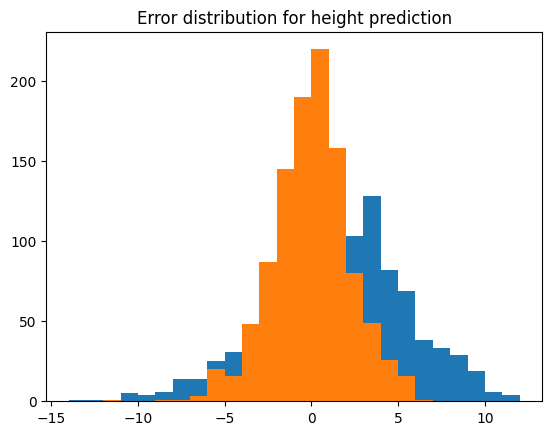

In [114]:
from sklearn.model_selection import train_test_split

Xn_train, Xn_test, yn_train, yn_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

#First classifier
clf_g10 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.2, max_depth=10, max_features=None, subsample=0.5 , random_state=random_state )
clf_g10.fit(Xn_train, yn_train)

y_pred_g10 = clf_g10.predict(Xn_test); y_err_g = yn_test-y_pred_g10; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=range(int(np.floor(np.min(y_err_g))), int(np.floor(np.max(y_err_g))) + 1, 1)); plt.title('Error distribution for height prediction')
print("Classifier results:")
print("Accuracy:", accuracy_score(yn_test, y_pred_g10)); print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

#Secondly regressor
clf_g11 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.2, max_depth=10, max_features=None, subsample=0.5 , random_state=random_state, )
clf_g11.fit(Xn_train, yn_train)

y_pred_g11 = clf_g11.predict(Xn_test); y_err_g = yn_test-y_pred_g11; y_err_in_1_g = y_err_g[y_err_g.abs()<=1]; y_err_in_2_g = y_err_g[y_err_g.abs()<=2]; y_err_in_3_g = y_err_g[y_err_g.abs()<=3]
plt.hist(y_err_g, bins=range(int(np.floor(np.min(y_err_g))), int(np.floor(np.max(y_err_g))) + 1, 1)); plt.title('Error distribution for height prediction')
print("\nRegressor results:")
print("Accuracy within 1 inch:", len(y_err_in_1_g)/len(y_err_g)); print("Accuracy within 2 inch:", len(y_err_in_2_g)/len(y_err_g)); print("Accuracy within 3 inch:", len(y_err_in_3_g)/len(y_err_g))

The classifier in this case does very poorly - only ~9% hit rate.<br>
The regressor does better, but not good enough.<br>

Overall, there is still some unbalance in the predictions even for the regressor.

## 4) Conclusion of results, discussion

### 4-a) F1 scores (classifiers)

In [116]:
from sklearn.metrics import f1_score

print("F1 scores:")
print("Tree classifier:", f1_score(y1_test, y1_pred, average='weighted'))
print("Random forest classifier:", f1_score(y1_test, y1_pred_f, average='weighted'))
#No f-score for random forest regressor, not a classifier
print("Ensemble forest 1:", f1_score(y1_test, y1_pred_e, average='weighted'))
print("Ensemble forest with averaging:", f1_score(y1_test, y1_pred_e2, average='weighted'))
print("Gradient boosted classifier, no hyperparameter tuning:", f1_score(y1_test, y_pred_g, average='weighted'))
print("Gradient boosted classifier, with hyperparameter tuning:", f1_score(y1_test, y_pred_g2, average='weighted'))
print("Gradient boosted classifier, with tuning, initialized from the random forest", f1_score(y1_test, y_pred_g5, average='weighted'))
print("Gradient boosted classifier, with shuffled data", f1_score(yn_test, y_pred_g10, average='weighted'))

F1 scores:
Tree classifier: 0.15361421828322733
Random forest classifier: 0.15528392076228717
Ensemble forest 1: 0.13736269639918183
Ensemble forest with averaging: 0.14860174985265773
Gradient boosted classifier, no hyperparameter tuning: 0.168873313224787
Gradient boosted classifier, with hyperparameter tuning: 0.13070776899487344
Gradient boosted classifier, with tuning, initialized from the random forest 0.14842883788958533
Gradient boosted classifier, with shuffled data 0.0865766424923313


#### 4-b) All model results comparison

Let's conclude our results:

| Model                                                | Data | Accuracy Score | +/-1 inch % | +/-2 inch % | +/-3 inch % | F1 Score | Error Range   |
|------------------------------------------------------|------|----------------|-------------|-------------|-------------|----------|---------------|
| Decision tree                                        | All  | 15.7%          | 42.8%       | 67.7%       | 81.3%       | 0.154    | -8 , 7        |
| Random forest classifier                             | All  | **17.6%**      | 45.3%       | 70.3%       | 83.7%       | **0.155**    | -8 , 6        |
| Ensemble forest 1                                    | All  | 15.5%          | 44.9%       | 70.2%       | 83.0%       | 0.137    | -8 , 6        |
| Ensemble forest averaging                            | All  | 16.2%          | **49.0%**   | **71.3%**   | **85.4%**   | 0.149    | -8 , 5        |
| Random forest regressor                              | All  | -              | **50.0%**   | **72.9%**   | **86.4%**   | -        | **-7 , 5**    |
| Gradient boosted classifier, no tuning, previous parameters | All  | 17.1%   | 44.5%       | 64.9%       | 78.9%       | 0.169    | -14 , 9       |
| Gradient boosted classifier, with hyperparameter tuning| All| 15.2%          | 41.6%       | 65.7%       | 79.3%       | 0.131    | -8 , 12       |
| Gradient boosted classifier, with tuning, initialized from RF| All | 15.8%   | 43.5%       | 67.4%       | 81.3%       | 0.148    | -8 , 6        |
| Gradient boosted regressor (from the RF model)       | All  | -              | **49.9%**       | 69.1%       | 84.5%       | -        | -8 , 6        |
| Gradient boosted classifier, with shuffled data  | Shuffled | 8.8%           | 28.1%       | 43.4%       | 59.8%       | 0.087    | -14 , 11      |
| Gradient boosted regressor, with shuffled data   | Shuffled | -              | 38.6%       | 67.1%       | 82.8%       | -        | -12 , 6       |

The gradient boosted methods underperformed likely because of lack of data, and the scikit-learn implementation not being state of the art (like XGBoost).<br>
**Classifiers**: In **accuracy**, only are used for evaluation, and the **random forest classifier** does the best with **17.6%** (and had the highest F-score), only the gradient boosted classifier initialized from its parameters manages to go above 17% accuracy. The **averaging ensemble forest method** however had the **best scores in all other categories (+-N inch ranges, error range)**, and came close to the best regressor method in all categories.<br>
**Regresssors**: We find that random forest regressor works, as the only model hitting **50% accuracy in the +-1 inch range**. It also hits the highest score in all other categories: **72.9% +-2 inch accuracy, 86.4% +-3 inch accuracy, and -7,5 error range**. Among the gradient boosted regressors, only the regressor initialized from the random forest does comparably, with 49.9% accuracy in +-1 inch range. <br>

This means, that the random forest regressor can **predict the height of a player within 1 inch half of the time**. This is a strong result for such a noisy problem.<br>

We also see that it is better to train the model with players not appearing in both train and test datasets.<br>

## Further notes: 

One should try methods such as `XGBoost` instead of scikit-learn's gradient boosting, it may learn faster and be more robust to local minima.<br>

One could also do the same for weight, instead of height.<br>
In fact, it would be logical to train multitarget models: 2D outputs with height and weight, similar to this: https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression_multioutput.html#sphx-glr-auto-examples-tree-plot-tree-regression-multioutput-py. <br>